# Quantifying collective identity online from self-defining hashtags:  hierarchical Stochastic Block Model (SBM) code

In [1]:
# Native imports.

import os
import sys
import gzip
import bz2
import pickle
import re

from time import time
from datetime import datetime
from itertools import chain, combinations, groupby
from collections import defaultdict, Counter

In [2]:
# Foreign imports.

import powerlaw
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyp
import matplotlib as mpl

from scipy.stats import spearmanr
from numpy.random import default_rng

In [3]:
# Matplotlib globals.

mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['font.family'] = 'serif'

In [4]:
# Colors.

offnavy = np.array([52,77,161])/256
lime = np.array([134,196,32])/256
FINALTOPE = np.array([240,238,230])/256

## Data

In [5]:
# Load full graph edge list.

_edgeinfo = []
with gzip.open('QuantifyingCollectiveIdentity_graph_edgelist.txt.gz',
               mode='rt',
               compresslevel=9) as f:
    
    # Skip header line.
    lines = iter(f.readlines())
    _ = next(lines)
    
    d_allvidpair_sharedhashtags = dict(map(lambda x: ((int(x[0]), int(x[1])), set(x[2].split(','))),
                                        [line.strip().split(' ') for line in lines]))
    
## Weighted edges list.
all_weighted_edges = [(v0, v1, len(hts)) for (v0, v1), hts in d_allvidpair_sharedhashtags.items()]
    
## Print a selection of edges of different weights, with their hashtags.
_keys = iter(d_allvidpair_sharedhashtags.keys())
_tosee = set(range(1, 5))
_seen = set()
while _seen != _tosee:
    
    pair = next(_keys)
    hts = d_allvidpair_sharedhashtags[pair]
    weight = len(hts)
    
    if weight not in _seen and weight in _tosee:
        print(pair, hts)
        _seen.add(weight)

(59322, 30551) {'#motoron', '#detroitbasketball', '#lgrw', '#onepride'}
(73037, 30551) {'#motoron', '#detroitbasketball', '#lgrw'}
(65270, 13312) {'#ua20', '#ua'}
(89405, 11190) {'#remission'}


## Graph processing

In [6]:
# Full graph.

print('Graph processing:')
sys.stdout.flush()

G = nx.Graph()
G.add_weighted_edges_from(all_weighted_edges)

# Largest component of the full graph.

Ggiant_nodeset = sorted(nx.connected_components(G), key=len, reverse=True)[0]
Ggiant = G.subgraph(Ggiant_nodeset).copy()

# Raw graph, component size CCDF

G_connected_components = sorted(nx.connected_components(G),
                                key=lambda x: len(x),
                                reverse=True)
G_connected_comp_sizes = [len(c) for c in G_connected_components]

print('\nOriginal graph, number of nodes: {:,}'.format(G.number_of_nodes()))
print('Original graph, number of edges: {:,}'.format(G.number_of_edges()))
print('Original graph, number of components: {:,}'.format(len(G_connected_comp_sizes)))

del G # Free memory.

print('\nGiant component, number of nodes: {:,}'.format(Ggiant.number_of_nodes()))
print('Giant component, number of edges: {:,}'.format(Ggiant.number_of_edges()))
sys.stdout.flush()

# Make edges for Ggiant with no degree=1 nodes (the 2-core network),
# get associated data structures.

## Prune off degree=1 nodes in giant component, creating the 2-core.

deg1nodes, deg1node_degs = zip(*filter(lambda x: x[1] == 1,
                                       Ggiant.degree(list(sorted(Ggiant.nodes()))))) # list of (node, degree) tups

## Get graph without degree=1 nodes (overwriting Ggiant).
Ggiant_nodeg1_nodeset = Ggiant_nodeset - set(deg1nodes)
Ggiant = Ggiant.subgraph(Ggiant_nodeg1_nodeset).copy()

print('Degrees of nodes removed:,', set(deg1node_degs)) # Test out the actual degrees removed.
del deg1node_degs
print('\nnumber of degree=1 nodes: {:,}'.format(len(deg1nodes)))
sys.stdout.flush()

weighted_edges = list(filter(lambda x: all(x[_k] in Ggiant_nodeg1_nodeset for _k in range(2)),
                                           all_weighted_edges))

del all_weighted_edges # Free memory.

## Get shared hashtags per vid pair for the pruned graph
## with no degree=1 nodes.

d_vidpair_sharedhashtags = dict(filter(lambda x: all(x[0][_k] in Ggiant_nodeg1_nodeset for _k in range(2)),
                                       d_allvidpair_sharedhashtags.items()))

del d_allvidpair_sharedhashtags # Free memory.

print('\nGiant component 2-core, number of nodes: {:,}'.format(Ggiant.number_of_nodes()))
print('Giant component 2-core, number of edges: {:,}'.format(Ggiant.number_of_edges()))
sys.stdout.flush()

Graph processing:

Original graph, number of nodes: 91,093
Original graph, number of edges: 14,757,865
Original graph, number of components: 648

Giant component, number of nodes: 89,647
Giant component, number of edges: 14,756,944
Degrees of nodes removed:, {1}

number of degree=1 nodes: 3,808

Giant component 2-core, number of nodes: 85,839
Giant component 2-core, number of edges: 14,753,136


## Infer hierarchical stochastic block model partition

It's worthwhile running this Jupyter notebook in an environment dedicated to graph-tool, as described in [the graph-tool installation documentation](https://git.skewed.de/count0/graph-tool/-/wikis/installation-instructions).

A dedicated [conda](https://conda.io/) environment was used for this analysis.

In [7]:
import graph_tool as gt

from graph_tool.inference import minimize_nested_blockmodel_dl, partition_overlap

In [8]:
# Make graph-tool version of the giant component 2-core.

Ggiant_gt = gt.Graph(directed=False)
edge_weights = Ggiant_gt.new_edge_property('int')

# Conversion dict between Louvain and graph-tool vertices.
d_nxv_gtv = {}
_gtidx = 0
for v0, v1, w in weighted_edges:
    # Populate the graph with vertices and record the 
    # vertex-to-graphtoolidx mapping.
    for v in [v0, v1]:
        if v not in d_nxv_gtv:
            d_nxv_gtv[v] = _gtidx
            _gtidx += 1
            Ggiant_gt.add_vertex()
    
    e = Ggiant_gt.add_edge(Ggiant_gt.vertex(d_nxv_gtv[v0]),
                           Ggiant_gt.vertex(d_nxv_gtv[v1]))
    edge_weights[e] = int(w)
    
# Reverse conversion dict between graph-tool and Louvain vertices.
d_gtv_nxv = {v:k for k, v in d_nxv_gtv.items()}
        
Ggiant_gt.edge_properties["weight"] = edge_weights # Make edge weight property map "internal".

In [9]:
Ggiant_gt

<Graph object, undirected, with 85839 vertices and 14753136 edges, 1 internal edge property, at 0x7fcf0f4ebeb0>

In [10]:
# Save graph-tool graph and conversion dictionary from
# nx Graph useranids to the indices used in graph-tool graph.

# Save graph-tool graph.
"""
Ggiant_gt.save('Ggiant_2core_GT.gt.xz', fmt='gt')
"""

# Save vertex conversion dictionary.
fname = 'Ggiant_2core_nx-to-gt_vtxconvdict.pkl'

"""
with open(fname, mode='wb') as f:
    pickle.dump(d_nxv_gtv, f)
"""

# Load vertex conversion dictionary.

"""
with open(fname, mode='rb') as f:
    d_nxv_gtv = pickle.load(f)
"""

"\nwith open(fname, mode='rb') as f:\n    d_nxv_gtv = pickle.load(f)\n"

In [11]:
# Infer hierarchical stochastic block model.
# Should take 6-12 hours.

# Uncomment to infer new hierarchical partition.
"""
print('Starting', datetime.now())
sys.stdout.flush()

t0 = time()

state = minimize_nested_blockmodel_dl(Ggiant_gt,
                                      state_args=dict(recs=[edge_weights],
                                                      rec_types=['discrete-geometric']))
tf = time()

print((tf-t0)/60, 'min.')
"""

# Save the partition.
fname = 'Ggiant_2core_NestedBlockState.pkl.gz'
"""
with gzip.open(fname, mode='wb', compresslevel=9) as f:
    pickle.dump(state, f)
"""

# Alternatively, load the partition used in the paper.

with gzip.open(fname, mode='rb', compresslevel=9) as f:
    state = pickle.load(f)


This inferred hierarchy has the lowest description length, shown below, of five attempts.  The other four, truncated to natural numbers:

59677231

59400638

59320690

59259313


In [12]:
print('Inferred hierarchy description length: {}'.format(state.entropy()))

Inferred hierarchy description length: 59166727.253182724


In [13]:
state.g

<Graph object, undirected, with 85839 vertices and 14753136 edges, 1 internal edge property, at 0x7fd1f224f850>

In [14]:
# Show number of nodes and groups in all levels.

state.print_summary()

l: 0, N: 85839, B: 1764
l: 1, N: 1764, B: 818
l: 2, N: 818, B: 464
l: 3, N: 464, B: 240
l: 4, N: 240, B: 167
l: 5, N: 167, B: 85
l: 6, N: 85, B: 46
l: 7, N: 46, B: 17
l: 8, N: 17, B: 6
l: 9, N: 6, B: 3
l: 10, N: 3, B: 2
l: 11, N: 2, B: 1
l: 12, N: 1, B: 1


## Compare Louvain and SBM hierarchy

In [15]:
from networkx.algorithms.community.quality import modularity
from graph_tool.inference import modularity as modularity_gt

### Louvain modularity by increasing level

In [15]:
# Load Louvain Ggiant hierarchical dendrogram

with open("QuantifyingCollectiveIdentity_2core_Louvainpartitiondendrogram.pkl", mode='rb') as f:
    Ggiant_partition_dendrogram = pickle.load(f)

In [16]:
# Get modularities for increasing levels of the Louvain hierarchy.

# Get projection of layers' partitions onto base graph.

assert set(Ggiant.nodes()) == set(Ggiant_partition_dendrogram[0].keys()), \
        'node labels are not identical'

## First layer mapping.
louvain_projections = [Ggiant_partition_dendrogram[0]]
## Higher layer mappings.
for level_id in range(1, len(Ggiant_partition_dendrogram)):
    
    proj = {}
    for baseid, lastlayerid in louvain_projections[level_id-1].items():
        proj[baseid] = Ggiant_partition_dendrogram[level_id][lastlayerid]
        
    louvain_projections.append(proj)

stats_perlevel_lv = []
for lk, lproj in enumerate(louvain_projections):
    
    # Translate graph-tool partition into a list of node sets.
    _d_c_v = {k: set() for k in set(lproj.values())}
    for v, c in lproj.items():
        _d_c_v[c].add(v)

    # Get modularity, record other stats per level.
    stats_perlevel_lv.append((lk+1,
                              modularity(Ggiant, _d_c_v.values(), weight='weight'),
                              len(_d_c_v),
                              np.mean([len(k) for k in _d_c_v.values()]),
                              np.std([len(k) for k in _d_c_v.values()]),
                              min([len(k) for k in _d_c_v.values()]),
                              max([len(k) for k in _d_c_v.values()])))
    
    print(lk)
    sys.stdout.flush()

0
1
2


In [17]:
stats_perlevel_lv_df = pd.DataFrame(stats_perlevel_lv, columns=['cluster_level',
                                                                'Q',
                                                                'cluster_count',
                                                                'mean_cluster_size',
                                                                'std_cluster_size',
                                                                'min_cluster_size',
                                                                'max_cluster_size'])

stats_perlevel_lv_df

,cluster_level,Q,cluster_count,mean_cluster_size,std_cluster_size,min_cluster_size,max_cluster_size
0,1,0.582443,4086,21.008076,203.461866,2,9582
1,2,0.622725,59,1454.898305,3285.235191,3,19316
2,3,0.623590,18,4768.833333,5606.331235,3,19337


In [176]:
# Make latex version of table.

print_cols = ['cluster_level',
              'Q',
              'cluster_count',
              'mean_cluster_size',
              'min_cluster_size',
              'max_cluster_size']

print_stats_perlevel_lv_df = stats_perlevel_lv_df[print_cols]

formatter = dict(zip(print_cols,
                     [lambda x: '{:,}'.format(x),
                      lambda x: '{:,.3f}'.format(x),
                      lambda x: '{:,}'.format(x),
                      lambda x: '{:,.2f}'.format(x),
                      lambda x: '{:,}'.format(x),
                      lambda x: '{:,}'.format(x)]))

print(print_stats_perlevel_lv_df.style.format(formatter=formatter).hide(axis="index").to_latex(hrules=True))

\begin{tabular}{rrrrrr}
\toprule
cluster_level & Q & cluster_count & mean_cluster_size & min_cluster_size & max_cluster_size \\
\midrule
1 & 0.582 & 4,086 & 21.01 & 2 & 9,582 \\
2 & 0.623 & 59 & 1,454.90 & 3 & 19,316 \\
3 & 0.624 & 18 & 4,768.83 & 3 & 19,337 \\
\bottomrule
\end{tabular}



### SBM modularity and other quantities per increasing bottom level, compared to Louvain top- and bottom-levels

In [18]:
# Get Louvain clusterings at top- and bottom-levels
# USING GRAPH-TOOL VERTEX INDICES AS THE COMMON BASIS.

d_lvl_lvclustering = {}
for lk in [0, 2]: # first- and top-level partitions
    lproj = louvain_projections[lk]
    
    # Translate graph-tool partition into a list of node sets.
    _d_c_v = {k: set() for k in set(lproj.values())}
    lproj_gtinds = np.zeros(len(lproj), dtype=np.int32)
    for v, c in lproj.items():
        _d_c_v[c].add(d_nxv_gtv[v]) # GRAPH-TOOL BASIS ENFORCED HERE
        lproj_gtinds[d_nxv_gtv[v]] = c
        
    d_lvl_lvclustering[lk] = lproj_gtinds

In [19]:
# Get modularities for increasing levels of the SBM hierarchy.

stats_perlevel_gt = []
for level_id in range(len(state.get_bstack())):
    
    # Translate graph-tool partition into a list of node sets.
    projected_level_partition = state.project_partition(level_id, 0)
    _d_c_v = {k: set() for k in set(projected_level_partition)}
    for v in state.g.vertices():
        c = projected_level_partition[v]
        _d_c_v[c].add(int(v))
    
    # Get modularity, record other stats per level.
    stats_perlevel_gt.append((level_id+1,
                              modularity_gt(state.g, projected_level_partition, gamma=1.0, weight=state.g.edge_properties['weight']),
                              len(_d_c_v),
                              np.mean([len(k) for k in _d_c_v.values()]),
                              min([len(k) for k in _d_c_v.values()]),
                              max([len(k) for k in _d_c_v.values()]),
                              partition_overlap(np.array(list(projected_level_partition)),
                                                              d_lvl_lvclustering[0], norm=True),
                              partition_overlap(np.array(list(projected_level_partition)),
                                                              d_lvl_lvclustering[2], norm=True)))

In [46]:
stats_perlevel_gt_df = pd.DataFrame(stats_perlevel_gt, columns=['cluster_level',
                                                                'Q',
                                                                'cluster_count',
                                                                'mean_cluster_size',
                                                                'min_cluster_size',
                                                                'max_cluster_size',
                                                                'clust_ovrlp_Louv_firstlvl',
                                                                'clust_ovrlp_Louv_toplvl'])

stats_perlevel_gt_df

,cluster_level,Q,cluster_count,mean_cluster_size,min_cluster_size,max_cluster_size,clust_ovrlp_Louv_firstlvl,clust_ovrlp_Louv_toplvl
0,1,0.123525,1764,48.661565,1,650,0.297184,0.043850
1,2,0.180007,818,104.937653,1,1056,0.277426,0.090926
2,3,0.297589,464,184.997845,1,3685,0.286455,0.187770
3,4,0.371778,240,357.662500,1,10269,0.243875,0.255898
4,5,0.455993,167,514.005988,1,18287,0.210813,0.346998
5,6,0.465224,85,1009.870588,1,33035,0.180617,0.369436
6,7,0.457468,46,1866.065217,1,56510,0.157749,0.353021
7,8,0.021775,17,5049.352941,1,78911,0.113841,0.239099
8,9,0.021830,6,14306.500000,30,78911,0.112513,0.235965
9,10,0.021475,3,28613.000000,118,78911,0.108366,0.234427


In [162]:
# Save/load stats per level (SBM)

fpath = 'statsperlevel_SBM.pkl'

"""
with open(fpath, mode='wb') as f:
    pickle.dump(stats_perlevel_gt, f)
"""

# Load.
with open(fpath, mode='rb') as f:
    stats_perlevel_gt = pickle.load(f)

In [177]:
# Make latex version of table.

print_cols = ['cluster_level',
              'Q',
              'cluster_count',
              'mean_cluster_size',
              'min_cluster_size',
              'max_cluster_size',
              'clust_ovrlp_Louv_firstlvl',
              'clust_ovrlp_Louv_toplvl']

print_stats_perlevel_gt_df = stats_perlevel_gt_df[print_cols]

formatter = dict(zip(print_cols,
                     [lambda x: '{:,}'.format(x),
                      lambda x: '{:,.3f}'.format(x),
                      lambda x: '{:,}'.format(x),
                      lambda x: '{:,.2f}'.format(x),
                      lambda x: '{:,}'.format(x),
                      lambda x: '{:,}'.format(x),
                      lambda x: '{:,.3f}'.format(x),
                      lambda x: '{:,.3f}'.format(x)]))

print(print_stats_perlevel_gt_df.style.format(formatter=formatter).hide(axis="index").to_latex(hrules=True))

\begin{tabular}{rrrrrrrr}
\toprule
cluster_level & Q & cluster_count & mean_cluster_size & min_cluster_size & max_cluster_size & clust_ovrlp_Louv_firstlvl & clust_ovrlp_Louv_toplvl \\
\midrule
1 & 0.124 & 1,764 & 48.66 & 1 & 650 & 0.297 & 0.044 \\
2 & 0.180 & 818 & 104.94 & 1 & 1,056 & 0.277 & 0.091 \\
3 & 0.298 & 464 & 185.00 & 1 & 3,685 & 0.286 & 0.188 \\
4 & 0.372 & 240 & 357.66 & 1 & 10,269 & 0.244 & 0.256 \\
5 & 0.456 & 167 & 514.01 & 1 & 18,287 & 0.211 & 0.347 \\
6 & 0.465 & 85 & 1,009.87 & 1 & 33,035 & 0.181 & 0.369 \\
7 & 0.457 & 46 & 1,866.07 & 1 & 56,510 & 0.158 & 0.353 \\
8 & 0.022 & 17 & 5,049.35 & 1 & 78,911 & 0.114 & 0.239 \\
9 & 0.022 & 6 & 14,306.50 & 30 & 78,911 & 0.113 & 0.236 \\
10 & 0.021 & 3 & 28,613.00 & 118 & 78,911 & 0.108 & 0.234 \\
11 & 0.021 & 2 & 42,919.50 & 6,928 & 78,911 & 0.108 & 0.234 \\
12 & 0.000 & 1 & 85,839.00 & 85,839 & 85,839 & 0.112 & 0.225 \\
13 & 0.000 & 1 & 85,839.00 & 85,839 & 85,839 & 0.112 & 0.225 \\
\bottomrule
\end{tabular}



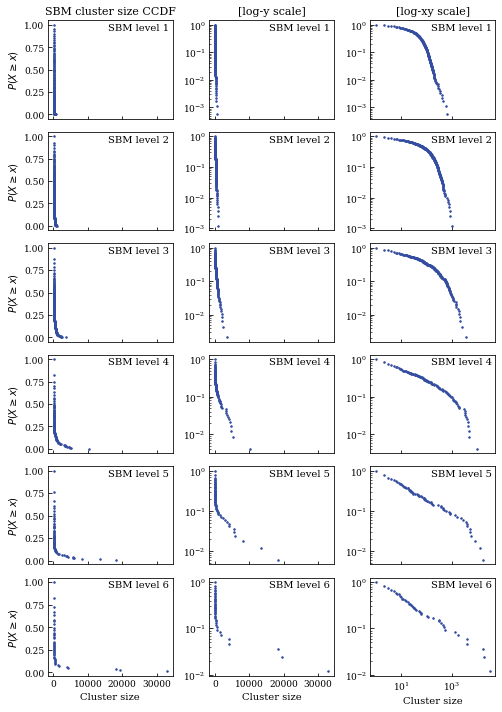

In [279]:
# Distribution of bottom-level community sizes

fig, axs = pyp.subplots(figsize=(7, 10), ncols=3, nrows=6)
axs = axs.reshape(6, 3)

for agglevel in range(6):

    _node_sizes = list(Counter(list(state.project_partition(agglevel, 0))).values())

    _fit = powerlaw.Fit(_node_sizes, discrete=True, verbose=False)

    ax = axs[agglevel, 0]

    _fit.plot_ccdf(ax=ax, original_data=True,
                          linestyle='', color=offnavy, marker='.', markersize=3, rasterized=True, zorder=0)
    

    ax.set_yscale('linear')
    ax.set_xscale('linear')

    ax.set_ylabel(r'$P(X \geq x)$')

    ax = axs[agglevel, 1]

    _fit.plot_ccdf(ax=ax, original_data=True,
                          linestyle='', color=offnavy, marker='.', markersize=3, rasterized=True, zorder=0)

    ax.set_yscale('log')
    ax.set_xscale('linear')

    ax = axs[agglevel, 2]

    _fit.plot_ccdf(ax=ax, original_data=True,
                          linestyle='', color=offnavy, marker='.', markersize=3, rasterized=True, zorder=0)

    ax.set_yscale('log')
    ax.set_xscale('log')
    
    for ax in axs[agglevel, :]:
        ax.annotate('SBM level {}'.format(agglevel+1),
                    xy=(0.97, 0.97), xycoords='axes fraction',
                    va='top', ha='right')
        
        
            
    
"""for ax in axs[:3, :].ravel():
    ax.set_xticklabels([])
"""

axs[0, 0].set_title('SBM cluster size CCDF')
axs[0, 1].set_title('[log-y scale]')
axs[0, 2].set_title('[log-xy scale]')
for ax in axs[5, :]:
    ax.set_xlabel('Cluster size')
    
# Set common y-axis limits for the final two axes in each row.
for k in range(6):
    these_yl0, these_yl1 = np.inf, -np.inf
    for ax in axs[k, 1:]:
        yl0, yl1 = ax.get_ylim()
        if (yl0 < these_yl0) and (yl0 > 0):
            these_yl0 = yl0
        if yl1 > these_yl1:
            these_yl1 = yl1
    for ax in axs[k, 1:]:
        ax.set_ylim(these_yl0, these_yl1)
        
# Set common x-axis limits for every column.
for k in range(3):
    these_xl0, these_xl1 = np.inf, -np.inf
    for ax in axs[:, k]:
        xl0, xl1 = ax.get_xlim()
        if (xl0 < these_xl0):
            these_xl0 = xl0
        if xl1 > these_xl1:
            these_xl1 = xl1
    for ax in axs[:, k]:
        ax.set_xlim(these_xl0, these_xl1)

# Remove x-tick labels for all but bottom row.
for k in range(5):
    for ax in axs[k, :]:
        ax.set_xticklabels([])
    
fig.tight_layout()

In [280]:
fig.savefig('SBM_clustersizes_dists_perlevel.pdf', format='pdf', dpi=300)

## Hashtag importance scores for prototypical labels

In [27]:
from scipy.sparse import csr_matrix
from itertools import chain, combinations

In [28]:
def get_hashtag_importance_scores(edges_weights_tups, communities_dict, d_uidpair_sharedhashtags):
    """
    Class for calculating modularity-related quantities of importance for hashtags.

    Args:
      edges_weights_tups (list): (uid0, uid1, weight) tuples
      communities_dict (dict): community label (int) -> set(uids)
      d_uidpair_sharedhashtags (dict): (uid0, uid1) -> set(hashtags shared)

    """

    edges_weights_tups = edges_weights_tups
    communities_dict = communities_dict

    # Make dict of nodes to indices for adjacency
    node_idcs = {v:k for k, v in enumerate(set(chain(*[[t[0], t[1]] for t in edges_weights_tups])))}

    # Make adjacency matrix.  Account for (i, j) and (j, i) in matrix.
    _pre_i, _pre_j, _pre_data = zip(*edges_weights_tups)
    A_i = [node_idcs[_p_i] for _p_i in _pre_i] + [node_idcs[_p_j] for _p_j in _pre_j]
    A_j = [node_idcs[_p_j] for _p_j in _pre_j] + [node_idcs[_p_i] for _p_i in _pre_i]
    A_data = list(_pre_data) + list(_pre_data)
    A_data = np.array(A_data)
    A = csr_matrix((A_data, (A_i, A_j)))
    A_i = A_i
    A_j = A_j
    A_data = A_data
    Ainds_tups = set(zip(A_i, A_j)) # Save for later.

    # Get non-weighted adjacency matrix, useful later.
    Aones_data = np.ones(len(A_i))
    Aones_data = Aones_data

    # Make component terms of B matrix entries (the terms in modularity summand).
    m = 0.5*A_data.sum()
    m = m
    k_i = np.array(A.sum(axis=1)).flatten()
    k_j = np.array(A.sum(axis=0)).flatten()

    d_hashtag_uidpairs = {} # TODO: is this necessary?
    d_hashtag_htind = {}
    hashtags_htindordered = []
    d_nodeidxpair_sharedhashtagidcs = {}
    htind = 0
    for uid0, uid1, weight in edges_weights_tups:
        uidpair = (uid0, uid1)
        sharedhashtags = d_uidpair_sharedhashtags[uidpair]
        for ht in sharedhashtags:
            if ht in d_hashtag_uidpairs:
                d_hashtag_uidpairs[ht].append(uidpair) # TODO: is this necessary?
            else:
                d_hashtag_uidpairs[ht] = [uidpair]
                d_hashtag_htind[ht] = htind
                hashtags_htindordered.append(ht)
                htind += 1

        nodeidxpair = (node_idcs[uidpair[0]], node_idcs[uidpair[1]])
        htidcs = np.array([d_hashtag_htind[ht] for ht in sharedhashtags])
        # Account for both orderings of adjacency matrix indices.
        d_nodeidxpair_sharedhashtagidcs[nodeidxpair] = htidcs
        d_nodeidxpair_sharedhashtagidcs[(nodeidxpair[1], nodeidxpair[0])] = htidcs
    #d_hashtag_uidpairs = d_hashtag_uidpairs # TODO: is this necessary?
    d_hashtag_htind = d_hashtag_htind
    hashtags_htindordered = hashtags_htindordered
    hashtagcount = len(d_hashtag_htind)
    Aindsordered_sharedhtidcs = [d_nodeidxpair_sharedhashtagidcs[Ainds] \
                                      for Ainds in zip(A_i, A_j)]

    # Pre-calculate B-matrix elements in the same order as
    # zip(A_i, A_j).
    B_data = np.array([_Aij - k_i[_i]*k_j[_j]/(2*m) \
                            for _Aij, _i, _j in zip(A_data, A_i, A_j)])

    # Get mask preserving pairs within the same communities.
    # Get csr_matrix version of this as well, to easily
    # obtain the betwen-community mask later (in combination
    # with the non-weighted adjacency matrix).
    #cmask = csr_matrix(A.shape)
    cmask_i = []
    cmask_j = []
    for commlabel, comm in communities_dict.items():
        # Iterate through the complete graph edges
        # from the community nodes.
        for uidpair in combinations(comm, 2):
            _idx0 = node_idcs[uidpair[0]]
            _idx1 = node_idcs[uidpair[1]]
            # Limit the *complete graph* edges from
            # this community to those actually in the
            # original graph.
            if (_idx0, _idx1) in Ainds_tups:
                cmask_i.extend([_idx0, _idx1])
                cmask_j.extend([_idx1, _idx0])
    cmask_i = np.array(cmask_i)
    cmask_j = np.array(cmask_j)
    cmaskinds_tups = set(zip(cmask_i, cmask_j)) # Save for later.
    cmask_data = np.ones(len(cmask_i))

    # Get mask preserving pairs BETWEEN the same communities.
    #
    # Start with non-weighted adjacency matrix, then subtract 1
    # for all pairs within the same community (already calculated).
    bmask_i = []
    bmask_j = []
    for Ainds in zip(A_i, A_j):
        if Ainds not in cmaskinds_tups:
            bmask_i.append(Ainds[0])
            bmask_j.append(Ainds[1])
    bmask_i = np.array(bmask_i)
    bmask_j = np.array(bmask_j)
    bmask_data = np.ones(len(bmask_i))

    assert len(A_data) == (len(cmask_data) + len(bmask_data)), \
            "Masks not partitioning Adjacency edges."

    # Get B-matrix entries specifically for within- and
    # between-communities edges.
    B_within_data = []
    B_between_data = []
    within_bool = []
    for Bij, Ainds in zip(B_data, zip(A_i, A_j)):
        if Ainds in cmaskinds_tups:
            B_within_data.append(Bij)
            within_bool.append(True)
        else:
            B_between_data.append(Bij)
            within_bool.append(False)
    B_within_data = B_within_data
    B_between_data = B_between_data
    within_bool = within_bool

    # Create mapping from node index to community.
    d_nodeidx_commlabel = {}
    for commlabel, comm in communities_dict.items():
        for uid in comm:
            d_nodeidx_commlabel[node_idcs[uid]] = commlabel
    # Make list of relevant communities for every edge, in
    # the order of A indices.  I.e. when an edge has at
    # least one incident node within a specified community.
    Aindsordered_relevantcomms = [set([d_nodeidx_commlabel[_s] for _s in Ainds]) \
                                  for Ainds in zip(A_i, A_j)]
        
    # Pre-allocate score array for all hashtags.
    perhashtag_scores = np.zeros(hashtagcount)
    
    # Pre-allocate score arrays for all hashtags,
    # focusing on particular communities.
    allcomms = set(communities_dict.keys())
    d_commfocus_perhashtag_scores = \
            {commlabel:np.zeros(hashtagcount) for commlabel in allcomms}
    
    # Keep track of which hashtags are involved in group focus at all.
    d_commfocus_involvedhtinds = {commlabel:set([]) for commlabel in allcomms}

    # Iterate over all edges in the network, updating modularity score
    # per hashtag globally and for specific community focus.
    for Ainds, Bij, wbool, htinds, relevantcomms in zip(zip(A_i, A_j),
                                                        B_data,
                                                        within_bool,
                                                        Aindsordered_sharedhtidcs,
                                                        Aindsordered_relevantcomms):
        if wbool:
            scorepart = Bij/len(htinds)
        else:
            scorepart = -Bij/len(htinds)
            
        # Update global modularity scores for hashtags in this edge.
        # htinds is an array, so can be used as an array index below.
        perhashtag_scores[htinds] += scorepart
        
        # Update community-focused modularity scores for hashtags
        # in this edge.
        for commlabel in relevantcomms:
            d_commfocus_perhashtag_scores[commlabel][htinds] += scorepart
            d_commfocus_involvedhtinds[commlabel].update(htinds)
        
    # Apply factor to all modularity scores
    perhashtag_scores /= (4*m) # 1/4m is the normalization
                                    # factor from Newman 2006,
                                    # PNAS, "Modularity and community
                                    # structure in networks"
    for commlabel in d_commfocus_perhashtag_scores.keys():
        d_commfocus_perhashtag_scores[commlabel] /= (4*m)
        
    # Store only those hashtags and their scores per focus community
    # if they are involved with the focus community.
    d_commfocus_hashtagimpscores = {}
    for commlabel, involvedhtinds in d_commfocus_involvedhtinds.items():
        commfocus_htscores = d_commfocus_perhashtag_scores[commlabel]
        cfhashtags = [hashtags_htindordered[htind] for htind in involvedhtinds]
        cfimpscores = [commfocus_htscores[htind] for htind in involvedhtinds]
        d_commfocus_hashtagimpscores[commlabel] = dict(zip(cfhashtags, cfimpscores))

    return hashtags_htindordered, perhashtag_scores, d_commfocus_hashtagimpscores

In [52]:
# Get original graph vertices for every SBM cluster at each level.

d_agglevel__comm_useranid_partition = {}

for agglevel in range(6):
    
    projected_level_partition = state.project_partition(agglevel, 0)

    _d_comm_useranid_Ggiant_level_partition = defaultdict(set)
    for gtv in state.g.vertices():
        comm = projected_level_partition[gtv]
        _d_comm_useranid_Ggiant_level_partition[comm].add(d_gtv_nxv[gtv])
    _d_comm_useranid_Ggiant_level_partition = dict(_d_comm_useranid_Ggiant_level_partition.items())
    
    d_agglevel__comm_useranid_partition[agglevel] = _d_comm_useranid_Ggiant_level_partition

In [181]:
# Get hashtag importance scores for each aggregated bottom-level.

"""
d_agglevel_importanceout = {}
for agglevel in range(6):
    
    _d_comm_useranid_Ggiant_agglevel_partition = d_agglevel__comm_useranid_partition[agglevel]
    
    # Get measure of importance of hashtags at first aggregation level.

    t0 = time()

    _hashtags_htindordered_agglevel, \
    _perhashtag_scores_agglevel, \
    _d_commfocus_hashtagimpscores_agglevel = \
            get_hashtag_importance_scores(weighted_edges,
                                          _d_comm_useranid_Ggiant_agglevel_partition,
                                          d_vidpair_sharedhashtags)
    
    d_agglevel_importanceout[agglevel] = (_hashtags_htindordered_agglevel, \
                                          _perhashtag_scores_agglevel, \
                                          _d_commfocus_hashtagimpscores_agglevel)
    
    tf = time()

    print('Level {} (index {}):'.format(agglevel+1, agglevel), (tf-t0)/60, 'min.')
"""

# Save/load importance scores for all levels.

fpath = 'SBM_labelimportanceout_perlevel.pkl'

# Save.
"""
with open(fpath, mode='wb') as f:
    pickle.dump(d_agglevel_importanceout, f)
"""

# Load.

with open(fpath, mode='rb') as f:
    d_agglevel_importanceout = pickle.load(f)

### Importance scores for selected top level

In [57]:
top_agglevel = 5

toplevel_hashtags_htindordered, toplevel_perhashtag_scores, d_toplevel_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[top_agglevel]

d_toplevel_comm_useranid_Ggiant_partition = d_agglevel__comm_useranid_partition[top_agglevel]

In [59]:
len(d_toplevel_comm_useranid_Ggiant_partition)

85

In [60]:
shared_hashtags_impscores = sorted(zip(toplevel_hashtags_htindordered, toplevel_perhashtag_scores),
                                       key=lambda x: x[1],
                                       reverse=True)

d_toplevel_hashtag_impscore = {ht: s for r, (ht, s) in enumerate(shared_hashtags_impscores)}

In [61]:
toplevel_commlabels_sorted, _ = zip(*sorted([(commlabel, len(comm)) for commlabel, comm in d_toplevel_comm_useranid_Ggiant_partition.items()],
                                   key=lambda x: x[1],
                                   reverse=True))

In [62]:
# Characterize all top-level communities.

commshowlim = 8

showN = 13

agglevel = 4

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

_d_comm_useranid_Ggiant_partition = d_agglevel__comm_useranid_partition[agglevel]

_shared_hashtags_impscores = sorted(zip(_hashtags_htindordered, _perhashtag_scores),
                                    key=lambda x: x[1],
                                    reverse=True)

_d_hashtag_impscore = {ht: s for r, (ht, s) in enumerate(_shared_hashtags_impscores)}

_commlabels_sorted, _commsizes_sorted = \
        zip(*sorted([(commlabel, len(comm)) for commlabel, comm in _d_comm_useranid_Ggiant_partition.items()],
                    key=lambda x: x[1],
                    reverse=True))

_allusercount = sum(_commsizes_sorted)

_ttl = 'LEVEL {}: Top {} top-level communities sorted by user fraction'.format(agglevel, showN)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for _commlabel, _commsize in list(zip(_commlabels_sorted, _commsizes_sorted))[:showN]:
    
    print('\n++++++++++ level-{} community {} ({:,} users, {:.3f}%):\n'.format(agglevel, _commlabel,
                                                                               _commsize, 100*(_commsize/_allusercount)))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[_commlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join([z[0] for z in zz]))


LEVEL 4: Top 13 top-level communities sorted by user fraction


++++++++++ level-4 community 101 (18,287 users, 21.304%):

#marketing
#music
#tech
#travel
#socialmedia
#writer
#entrepreneur
#author

++++++++++ level-4 community 102 (13,519 users, 15.749%):

#flyeaglesfly
#cowboysnation
#lakeshow
#coys
#bbn
#lakers
#httr
#gopackgo

++++++++++ level-4 community 168 (8,258 users, 9.620%):

#instagram
#bsu
#snapchat
#umes
#foamed
#ouat
#unt
#lucifer

++++++++++ level-4 community 96 (5,958 users, 6.941%):

#teamfollowback
#leo
#gramfam
#tamuc
#ig
#rippops
#vstate
#mvrp

++++++++++ level-4 community 31 (5,684 users, 6.622%):

#cfc
#tmc
#repealedthe8th
#afc
#rip
#southernnotstate
#aamu
#chelseafc

++++++++++ level-4 community 169 (5,672 users, 6.608%):

#exo
#got7
#nct
#day6
#wannaone
#findom
#nufc
#superjunior

++++++++++ level-4 community 37 (4,114 users, 4.793%):

#resist
#blacklivesmatter
#blm
#theresistance
#resistance
#fbr
#notmypresident
#metoo

++++++++++ level-4 community 35 (3,998 

### Importance scores per lower level

In [367]:
# Characterize first-level communities.

commshowlim = 8

showN = 13

agglevel = 0

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

_d_comm_useranid_Ggiant_partition = d_agglevel__comm_useranid_partition[agglevel]

_shared_hashtags_impscores = sorted(zip(_hashtags_htindordered, _perhashtag_scores),
                                    key=lambda x: x[1],
                                    reverse=True)

_d_hashtag_impscore = {ht: s for r, (ht, s) in enumerate(_shared_hashtags_impscores)}

_commlabels_sorted, _commsizes_sorted = \
        zip(*sorted([(commlabel, len(comm)) for commlabel, comm in _d_comm_useranid_Ggiant_partition.items()],
                    key=lambda x: x[1],
                    reverse=True))

_allusercount = sum(_commsizes_sorted)

_ttl = 'LEVEL {}: Top {} top-level communities sorted by user fraction'.format(agglevel, showN)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for _commlabel, _commsize in list(zip(_commlabels_sorted, _commsizes_sorted))[:showN]:
    
    print('\n++++++++++ level index {} community {} ({:,} users, {:.3f}%):\n'.format(agglevel, _commlabel,
                                                                               _commsize, 100*(_commsize/_allusercount)))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[_commlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join([z[0] for z in zz]))


LEVEL 0: Top 13 top-level communities sorted by user fraction


++++++++++ level index 0 community 70565 (650 users, 0.757%):

#queenof
#hamont
#mainbhichowkidar
#modifor2019
#babe
#dtr
#hdl
#dtu

++++++++++ level index 0 community 36794 (581 users, 0.677%):

#thehunt
#impinv
#pretoria
#wikipedia
#stopanimalabuse
#productofgrace
#personalinjury
#socialmovements

++++++++++ level index 0 community 48923 (442 users, 0.515%):

#ccsu
#blacklivesmatter✊🏽
#shiagenocide
#nosfaltan43
#fuckfascism
#translifematter
#supportdaca
#artsaveslives

++++++++++ level index 0 community 75193 (430 users, 0.501%):

#shadowhunters
#agentsofshield
#olicity
#westallen
#dynasty
#foreverjohnwalt
#idontmind
#letgofiym

++++++++++ level index 0 community 23642 (413 users, 0.481%):

#nhpolitics
#siuc
#hmg
#mas
#greengop
#siuc20
#prishtina
#wizard

++++++++++ level index 0 community 72828 (358 users, 0.417%):

#bu18
#dda
#zim
#cr7juve
#physiotherapy
#salford
#naturalresources
#favoured

++++++++++ level index 0 c

In [368]:
# Characterize 2nd-level communities.

commshowlim = 8

showN = 13

agglevel = 1

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

_d_comm_useranid_Ggiant_partition = d_agglevel__comm_useranid_partition[agglevel]

_shared_hashtags_impscores = sorted(zip(_hashtags_htindordered, _perhashtag_scores),
                                    key=lambda x: x[1],
                                    reverse=True)

_d_hashtag_impscore = {ht: s for r, (ht, s) in enumerate(_shared_hashtags_impscores)}

_commlabels_sorted, _commsizes_sorted = \
        zip(*sorted([(commlabel, len(comm)) for commlabel, comm in _d_comm_useranid_Ggiant_partition.items()],
                    key=lambda x: x[1],
                    reverse=True))

_allusercount = sum(_commsizes_sorted)

_ttl = 'LEVEL {}: Top {} top-level communities sorted by user fraction'.format(agglevel, showN)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for _commlabel, _commsize in list(zip(_commlabels_sorted, _commsizes_sorted))[:showN]:
    
    print('\n++++++++++ level index {} community {} ({:,} users, {:.3f}%):\n'.format(agglevel, _commlabel,
                                                                               _commsize, 100*(_commsize/_allusercount)))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[_commlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join([z[0] for z in zz]))


LEVEL 1: Top 13 top-level communities sorted by user fraction


++++++++++ level index 1 community 87 (1,056 users, 1.230%):

#ccsu
#endit
#madeindade
#tamucc20
#forthelove
#gsu2020
#alcorn19
#btsinnewark

++++++++++ level index 1 community 657 (868 users, 1.011%):

#presidential
#trump20
#trumppence2016
#trumppence
#kag🇺🇸
#ontherun
#kag20
#easterworshipper

++++++++++ level index 1 community 949 (846 users, 0.986%):

#queenof
#hamont
#mainbhichowkidar
#modifor2019
#babe
#dtr
#hdl
#dtu

++++++++++ level index 1 community 1360 (815 users, 0.949%):

#워너원
#세븐틴
#jungkook
#방탄소년단
#taehyung
#강다니엘
#민윤기
#김태형

++++++++++ level index 1 community 437 (766 users, 0.892%):

#jft96
#dontbuythesun
#dontbuythes*n
#sixtimes
#6times
#iju
#utmp
#midtown

++++++++++ level index 1 community 377 (746 users, 0.869%):

#jedifallenorder
#notnormal
#love4oneanother
#bootedgeedge
#boomers
#bernieisnotademocrat
#releasethefullreport
#systema

++++++++++ level index 1 community 1739 (714 users, 0.832%):

#thehunt


In [369]:
# Characterize third-level communities.

commshowlim = 8

showN = 13

agglevel = 2

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

_d_comm_useranid_Ggiant_partition = d_agglevel__comm_useranid_partition[agglevel]

_shared_hashtags_impscores = sorted(zip(_hashtags_htindordered, _perhashtag_scores),
                                    key=lambda x: x[1],
                                    reverse=True)

_d_hashtag_impscore = {ht: s for r, (ht, s) in enumerate(_shared_hashtags_impscores)}

_commlabels_sorted, _commsizes_sorted = \
        zip(*sorted([(commlabel, len(comm)) for commlabel, comm in _d_comm_useranid_Ggiant_partition.items()],
                    key=lambda x: x[1],
                    reverse=True))

_allusercount = sum(_commsizes_sorted)

_ttl = 'LEVEL {}: Top {} top-level communities sorted by user fraction'.format(agglevel, showN)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for _commlabel, _commsize in list(zip(_commlabels_sorted, _commsizes_sorted))[:showN]:
    
    print('\n++++++++++ level index {} community {} ({:,} users, {:.3f}%):\n'.format(agglevel, _commlabel,
                                                                               _commsize, 100*(_commsize/_allusercount)))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[_commlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join([z[0] for z in zz]))


LEVEL 2: Top 13 top-level communities sorted by user fraction


++++++++++ level index 2 community 164 (3,685 users, 4.293%):

#devops
#azure
#aws
#impinv
#office365
#kubernetes
#cloudnative
#trx

++++++++++ level index 2 community 588 (2,500 users, 2.912%):

#sbs
#queenof
#hamont
#osint
#amajoche
#mainbhichowkidar
#savetheoa
#modifor2019

++++++++++ level index 2 community 684 (2,199 users, 2.562%):

#tamuc
#tmc🏁
#mvrp
#freetheguys
#rwtw
#parody
#nsu🔰
#nsu20

++++++++++ level index 2 community 678 (2,177 users, 2.536%):

#gotiges
#sportsmarketing
#internetmarketing
#customer
#econ
#gogreek
#بريدة
#hackathon

++++++++++ level index 2 community 471 (2,068 users, 2.409%):

#maga
#kag
#trump2020
#2a
#prolife
#wwg1wga
#nra
#conservative

++++++++++ level index 2 community 83 (1,907 users, 2.222%):

#nasasocial
#enigma
#happinessbegins
#okstate21
#sewing
#aotearoa
#🇨🇦
#teamvixen

++++++++++ level index 2 community 599 (1,875 users, 2.184%):

#nevernation
#daddygang
#beeznation
#sagrad
#twi

In [370]:
# Characterize fourth-level communities.

commshowlim = 8

showN = 13

agglevel = 3

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

_d_comm_useranid_Ggiant_partition = d_agglevel__comm_useranid_partition[agglevel]

_shared_hashtags_impscores = sorted(zip(_hashtags_htindordered, _perhashtag_scores),
                                    key=lambda x: x[1],
                                    reverse=True)

_d_hashtag_impscore = {ht: s for r, (ht, s) in enumerate(_shared_hashtags_impscores)}

_commlabels_sorted, _commsizes_sorted = \
        zip(*sorted([(commlabel, len(comm)) for commlabel, comm in _d_comm_useranid_Ggiant_partition.items()],
                    key=lambda x: x[1],
                    reverse=True))

_allusercount = sum(_commsizes_sorted)

_ttl = 'LEVEL {}: Top {} top-level communities sorted by user fraction'.format(agglevel, showN)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for _commlabel, _commsize in list(zip(_commlabels_sorted, _commsizes_sorted))[:showN]:
    
    print('\n++++++++++ level index {} community {} ({:,} users, {:.3f}%):\n'.format(agglevel, _commlabel,
                                                                               _commsize, 100*(_commsize/_allusercount)))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[_commlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join([z[0] for z in zz]))


LEVEL 3: Top 13 top-level communities sorted by user fraction


++++++++++ level index 3 community 442 (10,269 users, 11.963%):

#tech
#music
#travel
#ai
#innovation
#digital
#digitalmarketing
#technology

++++++++++ level index 3 community 40 (5,145 users, 5.994%):

#exo
#got7
#nct
#day6
#wannaone
#findom
#superjunior
#bigbang

++++++++++ level index 3 community 13 (4,825 users, 5.621%):

#jucoproduct
#ncat
#11
#22
#23
#21
#uwg
#txsu

++++++++++ level index 3 community 274 (4,626 users, 5.389%):

#yeg
#edtech
#mieexpert
#siuc
#nhpolitics
#appleteacher
#newmusic
#ownambassador

++++++++++ level index 3 community 190 (4,435 users, 5.167%):

#tamuc
#tmc🏁
#daddygang
#mvrp
#freetheguys
#nevernation
#rwtw
#parody

++++++++++ level index 3 community 425 (4,066 users, 4.737%):

#foamed
#ouat
#shadowhunters
#lucifer
#riverdale
#agentsofshield
#twu
#عام_التوازن2018

++++++++++ level index 3 community 198 (3,765 users, 4.386%):

#tmc
#repealedthe8th
#rip
#southernnotstate
#aamu
#nccu
#repealthe

## Coherence

In [68]:
# Get probabilities for coherence for each bottom level of interest.

"""
# top_agglevel defined above
d_toplevel_comm_useranid_Ggiant_partition = d_agglevel__comm_useranid_partition[top_agglevel]

d_agglevel__bottomlevel_binary_probs = {}
d_agglevel__toplevel_given_bottomlevel_probs = {}
for agglevel in range(top_agglevel):
    
    _hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

    _d_comm_useranid_Ggiant_partition = d_agglevel__comm_useranid_partition[agglevel]
    
    # Get probabilities for information gain

    assert set(chain(*d_toplevel_comm_useranid_Ggiant_partition.values())) \
            == set(chain(*_d_comm_useranid_Ggiant_partition.values())), \
                'are not partitioning the same thing'

    uids_allset = set(chain(*_d_comm_useranid_Ggiant_partition.values()))
    alluidscount = len(uids_allset)

    d_toplevelcomm_probs = {str(comm):len(commuids)/alluidscount \
                            for comm, commuids in d_toplevel_comm_useranid_Ggiant_partition.items()}

    d_bottomlevel_binary_probs = {}
    for bottomlevel_comm, bottomlevel_comm_uids in _d_comm_useranid_Ggiant_partition.items():
        # Positive binary for this first-level community.
        d_bottomlevel_binary_probs[str(bottomlevel_comm)] = len(bottomlevel_comm_uids)/alluidscount
        # Negative binary for this first-level community.
        d_bottomlevel_binary_probs['not_{}'.format(bottomlevel_comm)] = len(uids_allset - bottomlevel_comm_uids)/alluidscount
        
    d_agglevel__bottomlevel_binary_probs[agglevel] = d_bottomlevel_binary_probs

    d_toplevel_given_bottomlevel_probs = {}
    for toplevel_comm, toplevel_comm_uids in d_toplevel_comm_useranid_Ggiant_partition.items():
        for bottomlevel_comm, bottomlevel_comm_uids in _d_comm_useranid_Ggiant_partition.items():
            # Top-level given positive binary first-level.
            d_toplevel_given_bottomlevel_probs[(str(toplevel_comm), str(bottomlevel_comm))] = \
                    len(bottomlevel_comm_uids & toplevel_comm_uids)/len(bottomlevel_comm_uids)
            # Top-level given negative binary first-level.
            d_toplevel_given_bottomlevel_probs[(str(toplevel_comm), 'not_{}'.format(bottomlevel_comm))] = \
                    len((uids_allset - bottomlevel_comm_uids) & toplevel_comm_uids)/len(uids_allset - bottomlevel_comm_uids)

    d_agglevel__toplevel_given_bottomlevel_probs[agglevel] = d_toplevel_given_bottomlevel_probs
    
    print(agglevel)
    sys.stdout.flush()
"""
    
# Save/load.

# Save binary bottom-level community probabilities for different levels.
fpath = 'SBM_binarycommprobs_bottomlevels.pkl'
"""
with open(fpath, mode='wb') as f:
    pickle.dump(d_agglevel__bottomlevel_binary_probs, f)
"""
# Load.
with open(fpath, mode='rb') as f:
    d_agglevel__bottomlevel_binary_probs = pickle.load(f)

# Save conditional probabilities for different level comparisons v. top level.
fpath = 'SBM_levelcompcondprobs_bottomlevels.pkl'
"""
with open(fpath, mode='wb') as f:
    pickle.dump(d_agglevel__toplevel_given_bottomlevel_probs, f)
"""
# Load.
with open(fpath, mode='rb') as f:
    d_agglevel__toplevel_given_bottomlevel_probs = pickle.load(f)

0
1
2
3
4


In [69]:
# Get binary first-level information gain on classifying top level

# top_agglevel defined above
uids_allset = set(chain(*d_agglevel__comm_useranid_partition[top_agglevel].values()))
alluidscount = len(uids_allset)
d_toplevelcomm_probs = {str(comm):len(commuids)/alluidscount \
                        for comm, commuids in d_agglevel__comm_useranid_partition[top_agglevel].items()}

# Top-level entropy.
H_toplevel = - sum(_p*np.log2(_p) for _p in d_toplevelcomm_probs.values())

d_agglevel__bottomlevel_binary_comm_mutinf = {}
for _bottomlevel, _d_bottomlevel_binary_probs in d_agglevel__bottomlevel_binary_probs.items():

    _bottomlevel_comms = [k for k in _d_bottomlevel_binary_probs.keys() if '_' not in k]
    
    _d_toplevel_given_bottomlevel_probs = d_agglevel__toplevel_given_bottomlevel_probs[_bottomlevel]

    _d_bottomlevel_binary_comm_mutinf = {}
    for _bottomlevel_comm in _bottomlevel_comms:

        condH = 0
        for _bottomlevel_binary_comm in [_bottomlevel_comm, 'not_{}'.format(_bottomlevel_comm)]:

            _bottomlevel_binary_p = _d_bottomlevel_binary_probs[_bottomlevel_binary_comm]

            cond_probs = [y for x, y in \
                          filter(lambda x: x[0][1] == _bottomlevel_binary_comm,
                                 _d_toplevel_given_bottomlevel_probs.items())]

            condH += _bottomlevel_binary_p * sum(_p*np.log2(_p) for _p in cond_probs if _p > 0)

        # Mutual information.
        _d_bottomlevel_binary_comm_mutinf[_bottomlevel_comm] = condH + H_toplevel
        
    d_agglevel__bottomlevel_binary_comm_mutinf[_bottomlevel] = _d_bottomlevel_binary_comm_mutinf

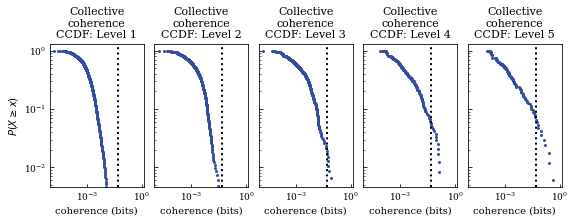

In [183]:
# Plot distribution of mutual information w.r.t. top level, for each bottom level.

fig, axs = pyp.subplots(figsize=(8, 3.2), ncols=5, sharex=True, sharey=True)


for agglevel in range(5):
    
    ax = axs[agglevel]

    _d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

    commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                       key=lambda x: x[1],
                                       reverse=True)

    _topbottomlevel_mutinfs = [x[1] for x in commlabels_mutinfs_sorted]

    cntsdict = Counter(_topbottomlevel_mutinfs)
    vals, counts = zip(*sorted(cntsdict.items(), key=lambda x: x[0]))
    cumsum = np.cumsum(counts)
    cdf = cumsum/cumsum[-1]
    ccdf = 1 - cdf

    ax.plot(vals, ccdf, '.', color=offnavy, markersize=4, rasterized=True)

    ax.set_xlabel('coherence (bits)')
    
    ax.set_title('Collective\ncoherence\nCCDF: Level {}'.format(agglevel+1))

    ax.set_xscale('log')
    ax.set_yscale('log')
    
for ax in axs:
    yl = ax.get_ylim()
    ax.loglog([0.05]*2, yl, ':k')
    ax.set_ylim(yl)
    
axs[0].set_ylabel(r'$P(X \geq x)$')

fig.tight_layout()

In [184]:
fig.savefig('SBM_coherencedist_perlevel.pdf', format='pdf', dpi=300)

In [310]:
# Characterize top coherence communities at specified bottom-level.

agglevel = 0

_d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

commshowlim = 4

showN = 10

_sizedict = dict(Counter(state.project_partition(agglevel, 0)))

_ttl = 'Top {} level-{} communities sorted by information gain WRT top-level'.format(showN, agglevel)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for commlabel, mutf in commlabels_mutinfs_sorted[:showN]:
    
    
    print('\n++++++++++ local community {}:\nMut. Inf. (mean uncertainty reduction) = {} bits'.format(commlabel, mutf))
    
    intcommlabel = int(commlabel)
    
    print('{} nodes'.format(_sizedict[intcommlabel]))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[intcommlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join([z[0] for z in zz]))


Top 10 level-0 communities sorted by information gain WRT top-level


++++++++++ local community 48923:
Mut. Inf. (mean uncertainty reduction) = 0.022963948711426152 bits
442 nodes
#ccsu
#blacklivesmatter✊🏽
#shiagenocide
#nosfaltan43

++++++++++ local community 72828:
Mut. Inf. (mean uncertainty reduction) = 0.018717155317823586 bits
358 nodes
#bu18
#dda
#zim
#cr7juve

++++++++++ local community 70565:
Mut. Inf. (mean uncertainty reduction) = 0.01704746242353883 bits
650 nodes
#queenof
#hamont
#mainbhichowkidar
#modifor2019

++++++++++ local community 70990:
Mut. Inf. (mean uncertainty reduction) = 0.015445664945175963 bits
299 nodes
#writersresist
#sciencebased
#heisrisen
#futrump

++++++++++ local community 47456:
Mut. Inf. (mean uncertainty reduction) = 0.015445664945175963 bits
299 nodes
#tamucc20
#forthelove
#alwayslove
#anonops

++++++++++ local community 36794:
Mut. Inf. (mean uncertainty reduction) = 0.015222905875315274 bits
581 nodes
#thehunt
#impinv
#pretoria
#wikipedia

++

In [311]:
# Characterize top coherence communities at specified bottom-level.

agglevel = 1

_d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

commshowlim = 4

showN = 10

_sizedict = dict(Counter(state.project_partition(agglevel, 0)))

_ttl = 'Top {} level-{} communities sorted by information gain WRT top-level'.format(showN, agglevel)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for commlabel, mutf in commlabels_mutinfs_sorted[:showN]:
    
    
    print('\n++++++++++ local community {}:\nMut. Inf. (mean uncertainty reduction) = {} bits'.format(commlabel, mutf))
    
    intcommlabel = int(commlabel)
    
    print('{} nodes'.format(_sizedict[intcommlabel]))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[intcommlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join([z[0] for z in zz]))


Top 10 level-1 communities sorted by information gain WRT top-level


++++++++++ local community 87:
Mut. Inf. (mean uncertainty reduction) = 0.0563131381629578 bits
1056 nodes
#ccsu
#endit
#madeindade
#tamucc20

++++++++++ local community 657:
Mut. Inf. (mean uncertainty reduction) = 0.04637672271936166 bits
868 nodes
#presidential
#trump20
#trumppence2016
#trumppence

++++++++++ local community 437:
Mut. Inf. (mean uncertainty reduction) = 0.04074390714915088 bits
766 nodes
#jft96
#dontbuythesun
#dontbuythes*n
#sixtimes

++++++++++ local community 377:
Mut. Inf. (mean uncertainty reduction) = 0.03924930130147608 bits
746 nodes
#jedifallenorder
#notnormal
#love4oneanother
#bootedgeedge

++++++++++ local community 1373:
Mut. Inf. (mean uncertainty reduction) = 0.029791121284174604 bits
439 nodes
#indiedev
#finalsay
#followbackproeu
#godotengine

++++++++++ local community 1606:
Mut. Inf. (mean uncertainty reduction) = 0.029362963566875955 bits
557 nodes
#ggmu
#bu18
#futsalista
#jlingz

In [312]:
# Characterize top coherence communities at specified bottom-level.

agglevel = 2

_d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

commshowlim = 4

showN = 10

_sizedict = dict(Counter(state.project_partition(agglevel, 0)))

_ttl = 'Top {} level-{} communities sorted by information gain WRT top-level'.format(showN, agglevel)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for commlabel, mutf in commlabels_mutinfs_sorted[:showN]:
    
    
    print('\n++++++++++ local community {}:\nMut. Inf. (mean uncertainty reduction) = {} bits'.format(commlabel, mutf))
    
    intcommlabel = int(commlabel)
    
    print('{} nodes'.format(_sizedict[intcommlabel]))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[intcommlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join(['{}: {:.8f}'.format(*z) for z in zz]))


Top 10 level-2 communities sorted by information gain WRT top-level


++++++++++ local community 471:
Mut. Inf. (mean uncertainty reduction) = 0.11729950059969552 bits
2068 nodes
#maga: 0.00713150
#kag: 0.00092050
#trump2020: 0.00048517
#2a: 0.00033742

++++++++++ local community 164:
Mut. Inf. (mean uncertainty reduction) = 0.1011256802506848 bits
3685 nodes
#devops: 0.00003307
#azure: 0.00000943
#aws: 0.00000502
#impinv: 0.00000223

++++++++++ local community 765:
Mut. Inf. (mean uncertainty reduction) = 0.0845830505896692 bits
1550 nodes
#blacklivesmatter: 0.00349524
#blm: 0.00084390
#translivesmatter: 0.00000885
#transrightsarehumanrights: 0.00000196

++++++++++ local community 552:
Mut. Inf. (mean uncertainty reduction) = 0.0827078434820745 bits
1518 nodes
#jedifallenorder: 0.00000009
#dogoodrecklessly: 0.00000009
#safarilive: 0.00000009
#fightwhitesupremacy: 0.00000009

++++++++++ local community 588:
Mut. Inf. (mean uncertainty reduction) = 0.06736572829538812 bits
2500 nodes
#

In [313]:
# Characterize top coherence communities at specified bottom-level.

agglevel = 3

_d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

commshowlim = 4

showN = 10

_sizedict = dict(Counter(state.project_partition(agglevel, 0)))

_ttl = 'Top {} level-{} communities sorted by information gain WRT top-level'.format(showN, agglevel)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for commlabel, mutf in commlabels_mutinfs_sorted[:showN]:
    
    
    print('\n++++++++++ local community {}:\nMut. Inf. (mean uncertainty reduction) = {} bits'.format(commlabel, mutf))
    
    intcommlabel = int(commlabel)
    
    print('{} nodes'.format(_sizedict[intcommlabel]))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[intcommlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join(['{}: {:.8f}'.format(*z) for z in zz]))


Top 10 level-3 communities sorted by information gain WRT top-level


++++++++++ local community 442:
Mut. Inf. (mean uncertainty reduction) = 0.31759508535046477 bits
10269 nodes
#tech: 0.00335876
#music: 0.00308419
#travel: 0.00256919
#ai: 0.00159317

++++++++++ local community 353:
Mut. Inf. (mean uncertainty reduction) = 0.20399737479608726 bits
3342 nodes
#blacklivesmatter: 0.01297192
#blm: 0.00341077
#resist: 0.00014737
#blackgirlmagic: 0.00004134

++++++++++ local community 13:
Mut. Inf. (mean uncertainty reduction) = 0.12895341612728828 bits
4825 nodes
#jucoproduct: 0.00058921
#ncat: 0.00031385
#11: 0.00014530
#22: 0.00010604

++++++++++ local community 274:
Mut. Inf. (mean uncertainty reduction) = 0.12887573317486556 bits
4626 nodes
#yeg: 0.00001923
#edtech: 0.00001669
#mieexpert: 0.00000171
#siuc: 0.00000095

++++++++++ local community 190:
Mut. Inf. (mean uncertainty reduction) = 0.11781525952287542 bits
4435 nodes
#tamuc: 0.00001130
#tmc🏁: 0.00000318
#daddygang: 0.00000291

In [314]:
# Characterize top coherence communities at specified bottom-level.

agglevel = 4

_d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

commshowlim = 4

showN = 10

_sizedict = dict(Counter(state.project_partition(agglevel, 0)))

_ttl = 'Top {} level-{} communities sorted by information gain WRT top-level'.format(showN, agglevel)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

for commlabel, mutf in commlabels_mutinfs_sorted[:showN]:
    
    
    print('\n++++++++++ local community {}:\nMut. Inf. (mean uncertainty reduction) = {} bits'.format(commlabel, mutf))
    
    intcommlabel = int(commlabel)
    
    print('{} nodes'.format(_sizedict[intcommlabel]))

    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[intcommlabel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    zz = focusedimpscores[:commshowlim]
    print('\n'.join(['{}: {:.8f}'.format(*z) for z in zz]))


Top 10 level-4 communities sorted by information gain WRT top-level


++++++++++ local community 101:
Mut. Inf. (mean uncertainty reduction) = 0.7472504594621217 bits
18287 nodes
#marketing: 0.01210579
#music: 0.01049470
#tech: 0.00720984
#travel: 0.00655263

++++++++++ local community 102:
Mut. Inf. (mean uncertainty reduction) = 0.42670150360376446 bits
13519 nodes
#flyeaglesfly: 0.00189802
#cowboysnation: 0.00129754
#lakeshow: 0.00122073
#coys: 0.00108877

++++++++++ local community 37:
Mut. Inf. (mean uncertainty reduction) = 0.2775245813564555 bits
4114 nodes
#resist: 0.01429664
#blacklivesmatter: 0.01297192
#blm: 0.00458171
#theresistance: 0.00277874

++++++++++ local community 35:
Mut. Inf. (mean uncertainty reduction) = 0.27166813410679813 bits
3998 nodes
#maga: 0.00713150
#ynwa: 0.00450815
#lfc: 0.00335463
#kag: 0.00093731

++++++++++ local community 96:
Mut. Inf. (mean uncertainty reduction) = 0.16213885021957664 bits
5958 nodes
#teamfollowback: 0.00038962
#leo: 0.00004640
#

In [ ]:
## Create

In [300]:
# Create DataFrame table for prototypical labels.

agglevel = 2

_d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

commshowlim = 10

_sizedict = dict(Counter(state.project_partition(agglevel, 0)))

top_labels_percluster = []
for commlabel, mutf in commlabels_mutinfs_sorted:
    
    if mutf > 0.05:

        intcommlabel = int(commlabel)

        focusedimpscores = sorted(_d_commfocus_hashtagimpscores[intcommlabel].items(),
                                  key=lambda x: x[1],
                                  reverse=True)

        zz = focusedimpscores[:commshowlim]
        
        top_labels_percluster.append(zz)
        
clusternum = len(top_labels_percluster)

chunknum = 5 # Number of topics to group into one table.

# Iterate over groups, or "chunks", of topics and
# create DataFrames for each chunk.
topword_dfs = []
for e in range(chunknum, clusternum+chunknum, chunknum):
    clusters_chunk = []
    for i in range(e-chunknum, e):
        if i < clusternum:
            clusters_chunk.append(top_labels_percluster[i])
        
    # Collect the top words for each topic in this chunk.
    topwordvecs = []
    for cluster in clusters_chunk:
        topwordvecs.append(np.array([z[0] for z in cluster]))

    # Combine the top words into a single DataFrame.
    topwordarr = np.vstack(topwordvecs).T
    names = ['Cluster {}'.format(k) for k in range(e-chunknum, e, 1)[:len(topwordarr[1])]]
    topword_df = pd.DataFrame(topwordarr, columns=names)
    topword_dfs.append(topword_df)
    
# Display the first chunk's table.
topword_dfs[0]

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,#maga,#devops,#blacklivesmatter,#jedifallenorder,#sbs
1,#kag,#azure,#blm,#dogoodrecklessly,#queenof
2,#trump2020,#aws,#translivesmatter,#safarilive,#hamont
3,#2a,#impinv,#transrightsarehumanrights,#fightwhitesupremacy,#osint
4,#prolife,#office365,#blacklivesmatter✊🏾,#ibelieveyou,#amajoche
5,#wwg1wga,#kubernetes,#tlm,#disarmhate,#mainbhichowkidar
6,#nra,#cloudnative,#muslimlivesmatter,#veteransresist,#savetheoa
7,#conservative,#trx,#ccsu,#equalrightsforall,#modifor2019
8,#tcot,#iiot,#dst1913,#nonazis,#newindia
9,#qanon,#sharepoint,#prayforsudan,#resist✊🏾,#babe


In [301]:
# Place all top label chunk tables into a single table.

latex_partstrings = []
for k, df in enumerate(topword_dfs):
    
    if k == 0:
        
        latex_partstrings.append('\n'.join(df.style.hide(axis="index").to_latex(hrules=True).split('\n')[:-3]))
    
    elif k == len(topword_dfs)-1:
        
        latex_partstrings.append('\n'.join(df.style.hide(axis="index").to_latex(hrules=True).split('\n')[2:]))
    
    else:
        
        latex_partstrings.append('\n'.join(df.style.hide(axis="index").to_latex(hrules=True).split('\n')[2:-3]))
    
out = '\n\midrule\n'.join(latex_partstrings)

print(re.sub('#', '\\#', out))

\begin{tabular}{lllll}
\toprule
Cluster 0 & Cluster 1 & Cluster 2 & Cluster 3 & Cluster 4 \\
\midrule
\#maga & \#devops & \#blacklivesmatter & \#jedifallenorder & \#sbs \\
\#kag & \#azure & \#blm & \#dogoodrecklessly & \#queenof \\
\#trump2020 & \#aws & \#translivesmatter & \#safarilive & \#hamont \\
\#2a & \#impinv & \#transrightsarehumanrights & \#fightwhitesupremacy & \#osint \\
\#prolife & \#office365 & \#blacklivesmatter✊🏾 & \#ibelieveyou & \#amajoche \\
\#wwg1wga & \#kubernetes & \#tlm & \#disarmhate & \#mainbhichowkidar \\
\#nra & \#cloudnative & \#muslimlivesmatter & \#veteransresist & \#savetheoa \\
\#conservative & \#trx & \#ccsu & \#equalrightsforall & \#modifor2019 \\
\#tcot & \#iiot & \#dst1913 & \#nonazis & \#newindia \\
\#qanon & \#sharepoint & \#prayforsudan & \#resist✊🏾 & \#babe \\
\midrule
Cluster 5 & Cluster 6 & Cluster 7 & Cluster 8 \\
\midrule
\#ynwa & \#gotiges & \#tamuc & \#nasasocial \\
\#lfc & \#sportsmarketing & \#tmc🏁 & \#enigma \\
\#jft96 & \#internetmarketi

In [298]:
# Create DataFrame table for prototypical labels.

agglevel = 3

_d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

commshowlim = 10

_sizedict = dict(Counter(state.project_partition(agglevel, 0)))

top_labels_percluster = []
for commlabel, mutf in commlabels_mutinfs_sorted:
    
    if mutf > 0.05:

        intcommlabel = int(commlabel)

        focusedimpscores = sorted(_d_commfocus_hashtagimpscores[intcommlabel].items(),
                                  key=lambda x: x[1],
                                  reverse=True)

        zz = focusedimpscores[:commshowlim]
        
        top_labels_percluster.append(zz)
        
clusternum = len(top_labels_percluster)

chunknum = 5 # Number of topics to group into one table.

# Iterate over groups, or "chunks", of topics and
# create DataFrames for each chunk.
topword_dfs = []
for e in range(chunknum, clusternum+chunknum, chunknum):
    clusters_chunk = []
    for i in range(e-chunknum, e):
        if i < clusternum:
            clusters_chunk.append(top_labels_percluster[i])
        
    # Collect the top words for each topic in this chunk.
    topwordvecs = []
    for cluster in clusters_chunk:
        topwordvecs.append(np.array([z[0] for z in cluster]))

    # Combine the top words into a single DataFrame.
    topwordarr = np.vstack(topwordvecs).T
    names = ['Cluster {}'.format(k) for k in range(e-chunknum, e, 1)[:len(topwordarr[1])]]
    topword_df = pd.DataFrame(topwordarr, columns=names)
    topword_dfs.append(topword_df)
    
# Display the first chunk's table.
topword_dfs[0]

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,#tech,#blacklivesmatter,#jucoproduct,#yeg,#tamuc
1,#music,#blm,#ncat,#edtech,#tmc🏁
2,#travel,#resist,#11,#mieexpert,#daddygang
3,#ai,#blackgirlmagic,#22,#siuc,#mvrp
4,#innovation,#notmypresident,#23,#nhpolitics,#freetheguys
5,#digital,#translivesmatter,#21,#appleteacher,#nevernation
6,#digitalmarketing,#blacklivesmatter✊🏾,#uwg,#newmusic,#rwtw
7,#technology,#transrightsarehumanrights,#txsu,#ownambassador,#parody
8,#fintech,#believewomen,#pvamu,#hmg,#beeznation
9,#iot,#protecttranslives,#24,#econdev,#nsu🔰


In [299]:
# Place all top label chunk tables into a single table.

latex_partstrings = []
for k, df in enumerate(topword_dfs):
    
    if k == 0:
        
        latex_partstrings.append('\n'.join(df.style.hide(axis="index").to_latex(hrules=True).split('\n')[:-3]))
    
    elif k == len(topword_dfs)-1:
        
        latex_partstrings.append('\n'.join(df.style.hide(axis="index").to_latex(hrules=True).split('\n')[2:]))
    
    else:
        
        latex_partstrings.append('\n'.join(df.style.hide(axis="index").to_latex(hrules=True).split('\n')[2:-3]))
    
out = '\n\midrule\n'.join(latex_partstrings)

print(re.sub('#', '\\#', out))

\begin{tabular}{lllll}
\toprule
Cluster 0 & Cluster 1 & Cluster 2 & Cluster 3 & Cluster 4 \\
\midrule
\#tech & \#blacklivesmatter & \#jucoproduct & \#yeg & \#tamuc \\
\#music & \#blm & \#ncat & \#edtech & \#tmc🏁 \\
\#travel & \#resist & \#11 & \#mieexpert & \#daddygang \\
\#ai & \#blackgirlmagic & \#22 & \#siuc & \#mvrp \\
\#innovation & \#notmypresident & \#23 & \#nhpolitics & \#freetheguys \\
\#digital & \#translivesmatter & \#21 & \#appleteacher & \#nevernation \\
\#digitalmarketing & \#blacklivesmatter✊🏾 & \#uwg & \#newmusic & \#rwtw \\
\#technology & \#transrightsarehumanrights & \#txsu & \#ownambassador & \#parody \\
\#fintech & \#believewomen & \#pvamu & \#hmg & \#beeznation \\
\#iot & \#protecttranslives & \#24 & \#econdev & \#nsu🔰 \\
\midrule
Cluster 5 & Cluster 6 & Cluster 7 & Cluster 8 & Cluster 9 \\
\midrule
\#maga & \#ynwa & \#writer & \#heatnation & \#exo \\
\#kag & \#lfc & \#author & \#keeppounding & \#got7 \\
\#trump2020 & \#jft96 & \#vegan & \#vfl & \#nct \\
\#2a & \#d

### How do Louvain bottom-level communities relate to SBM communities at increasing levels?

In [122]:
# Get modularities for increasing levels of the SBM hierarchy.

# Get similarities of the SBM cluster covering for nodes in each Louvain-assigned 
# cluster (these Louvain clusters (in d_lvl_lvclustering[0]) are already
# translated to the graph-tool "basis" of node index.
lv_firstlevel_partition_ingtvidcs = d_lvl_lvclustering[0]
_d_lvc_v = {k: set() for k in set(lv_firstlevel_partition_ingtvidcs)}
for v in state.g.vertices():
    c = lv_firstlevel_partition_ingtvidcs[int(v)]
    _d_lvc_v[c].add(int(v))
for lvc, vs in _d_lvc_v.items():
    _d_lvc_v[lvc] = np.array(list(vs))

d_lvl__lvc_coveredgtsim = {}
for agglevel in range(top_agglevel):
    
    d_lvc_coveredgtsim = {}
    # Each lvc, lvc_gtinds describes the Louvain cluster index and its
    # constituent vertices in the graph-tool vertex basis.
    for lvc, lvc_gtinds in _d_lvc_v.items():
        
        _sbm_partition = np.array(list(state.project_partition(agglevel, 0)))
        
        # Get the SBM cluster labels for these indices.
        SBM_subcs_cnts = Counter(_sbm_partition[lvc_gtinds])
        
        # XXX need this?
        # Get the Louvain cluster labels in the same order.
        lv_subcs = lv_firstlevel_partition_ingtvidcs[lvc_gtinds]
        
        # For each SBM cluster with some coverage of the Louvain cluster,
        # get the overlap and calculate Jaccard index.
        lv_cnt = len(lvc_gtinds)
        overlaps = [SBM_cnt/lv_cnt for SBM_subc, SBM_cnt in SBM_subcs_cnts.items()]
    
        # Get maximum-Jaccard index SBM cluster with respect to the Louvain cluster.
        best_overlap = max(overlaps)
        
        d_lvc_coveredgtsim[lvc] = best_overlap
    
    d_lvl__lvc_coveredgtsim[agglevel] = d_lvc_coveredgtsim
    
    print(agglevel)
    sys.stdout.flush()


0
1
2
3
4


In [137]:
# Save/load covering stats per Louvain bottom-level community, from above cell.

fname = "LouvainSBMcomp_coverstats_perlevel.pkl"

# Save.
"""
with open(fname, mode='wb') as f:
    pickle.dump(d_lvl__lvc_coveredgtsim, f)
"""
    
# Load.
with open(fname, mode='rb') as f:
    d_lvl__lvc_coveredgtsim = pickle.load(f)

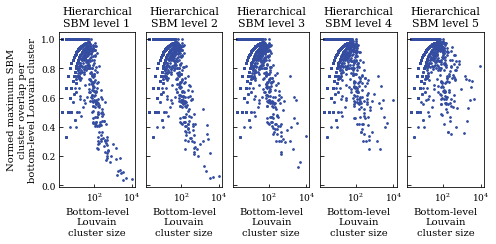

In [281]:
# Normed max cluster overlap per Louvain bottom-level cluster, x axis is Louvain community size.

# Get sizes per Louvain first-level clustering.
lv_firstlevel_partition_ingtvidcs = d_lvl_lvclustering[0]
_d_lvc_size = Counter(lv_firstlevel_partition_ingtvidcs)

fig, axs = pyp.subplots(figsize=(7, 3.5), ncols=top_agglevel, sharex=True, sharey=True)

for agglevel in range(top_agglevel):

    _lv_sizes = []
    _lv_gt_clustsims = []
    for lv_c, sim in d_lvl__lvc_coveredgtsim[agglevel].items():
        _lv_sizes.append(_d_lvc_size[lv_c])
        _lv_gt_clustsims.append(sim)
        
    ax = axs[agglevel]
    
    ax.scatter(_lv_sizes, _lv_gt_clustsims, marker='o', s=3, color=offnavy, rasterized=True)
    
    ax.set_xscale('log')
    
    ax.set_title('Hierarchical\nSBM level {}'.format(agglevel+1))
    ax.set_xlabel('Bottom-level\nLouvain\ncluster size')
    
axs[0].set_ylabel('Normed maximum SBM\ncluster overlap per\nbottom-level Louvain cluster')
    
fig.tight_layout(w_pad=0.5)

In [282]:
fig.savefig('matched_Louvaincluster_overlap_per_SBMlevel_sizex.pdf', format='pdf', dpi=300)

In [125]:
# Load binary first-level information gain on classifying top level
# from Louvain hierarchical partition.

fpath = 'Louvain_1stlvl_binary_comm_mutinf.pkl'
    
with open(fpath, mode='rb') as f:
    d_lv_firstlevel_binary_comm_mutinf = pickle.load(f)

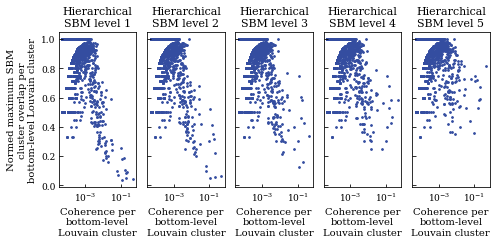

In [283]:
# Normed max cluster overlap per Louvain bottom-level cluster, x axis is Louvain coherence.

fig, axs = pyp.subplots(figsize=(7, 3.5), ncols=top_agglevel, sharex=True, sharey=True)

for agglevel in range(top_agglevel):

    _lv_mutinfs = []
    _lv_gt_clustsims = []
    for lv_c, sim in d_lvl__lvc_coveredgtsim[agglevel].items():
        _lv_mutinfs.append(d_lv_firstlevel_binary_comm_mutinf[str(lv_c)])
        _lv_gt_clustsims.append(sim)
        
    ax = axs[agglevel]
    
    ax.scatter(_lv_mutinfs, _lv_gt_clustsims, marker='o', s=3, color=offnavy, rasterized=True)
    
    ax.set_xscale('log')
    
    ax.set_title('Hierarchical\nSBM level {}'.format(agglevel+1))
    ax.set_xlabel('Coherence per\nbottom-level\nLouvain cluster')
    
axs[0].set_ylabel('Normed maximum SBM\ncluster overlap per\nbottom-level Louvain cluster')
    
fig.tight_layout()

In [284]:
fig.savefig('matched_Louvaincluster_overlap_per_SBMlevel.pdf', format='pdf', dpi=300)

#### Compare SBM cluster coherence against Louvain level cluster coherence head-to-head

...by maximizing overall cluster overlap score between the Louvain first level and increasing SBM levels..

In [139]:
from scipy.optimize import linear_sum_assignment

In [303]:
# Perform the linear-sum maximization assignment of clusters
# from Louvain first level to each SBM level.

# Uncomment to run.
"""
# These Louvain clusters (in d_lvl_lvclustering[0]) are already
# translated to the graph-tool "basis" of node index.
lv_firstlevel_partition_ingtvidcs = d_lvl_lvclustering[0]
_d_lvc_lvci = {} # Need Louvain cluster identity labels to be consecutive from zero.
lvci = 0
for lvc in set(list(lv_firstlevel_partition_ingtvidcs)):
    _d_lvc_lvci[lvc] = lvci
    lvci += 1
_d_lvci_lvc = {v:k for k, v in _d_lvc_lvci.items()}
_lv_partition_cconsec = np.array([_d_lvc_lvci[lvc] for lvc in lv_firstlevel_partition_ingtvidcs])
    
# Make a "profit matrix" comparing Louvain clusters to SBM level clusters,
# for each SBM level.  Then find the "profit"-maximizing assignment.
d_agglevel_optassignments = {}
d_agglevel__sbmci_sbmc = {}
d_agglevel__lvcisbmci_sizesoverlapunion = {}
for agglevel in range(top_agglevel):
    
    # Get the SBM level partition.
    sbm_partition = state.project_partition(agglevel, 0)
    _d_sbmc_sbmci = {} # Need SBM level cluster identity labels to be consecutive from zero.
    sbmci = 0
    for sbmc in set(list(sbm_partition)):
        _d_sbmc_sbmci[sbmc] = sbmci
        sbmci += 1
    d_agglevel__sbmci_sbmc[agglevel] = {v:k for k, v in _d_sbmc_sbmci.items()}
    _sbm_partition_cconsec = np.array([_d_sbmc_sbmci[sbmc] for sbmc in sbm_partition])
    
    # Get "profit matrix" by getting the overlap over all pairs of clusters between
    # the two partitions.
    profit_mat = np.zeros((lvci, sbmci))
    _lvcisbmci_sizesoverlapunion = {}
    for _lvci in range(lvci):
        for _sbmci in range(sbmci):
            lvsize = (_lv_partition_cconsec == _lvci).sum()
            sbmsize = (_sbm_partition_cconsec == _sbmci).sum()
            overlap = ((_lv_partition_cconsec == _lvci) & (_sbm_partition_cconsec == _sbmci)).sum()
            union = ((_lv_partition_cconsec == _lvci) | (_sbm_partition_cconsec == _sbmci)).sum()
            
            profit_mat[_lvci, _sbmci] = overlap
            _lvcisbmci_sizesoverlapunion[(_lvci, _sbmci)] = [lvsize, sbmsize, overlap, union]
    
    d_agglevel_optassignments[agglevel] = linear_sum_assignment(profit_mat, maximize=True)
    d_agglevel__lvcisbmci_sizesoverlapunion[agglevel] = _lvcisbmci_sizesoverlapunion
    
    print(agglevel)
    sys.stdout.flush()

d_lvl_lvc_sbmc_mutinfcomp_lsassigned = {}
for agglevel, assignments in d_agglevel_optassignments.items():
    
    lvc_sbmc_mutinfcomp = []
    for lvci_assigned, smbci_assigned in zip(*assignments):
        
        lvc = _d_lvci_lvc[lvci_assigned]
        sbmc = d_agglevel__sbmci_sbmc[agglevel][smbci_assigned]
        
        lvmutinf = d_lv_firstlevel_binary_comm_mutinf[str(lvc)]
        sbmmutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel][str(sbmc)]
        
        lvsize, sbmsize, overlap, union = \
                d_agglevel__lvcisbmci_sizesoverlapunion[agglevel][(lvci_assigned, smbci_assigned)]
        
        lvc_sbmc_mutinfcomp.append((lvc,
                                    lvmutinf,
                                    sbmc,
                                    sbmmutinf,
                                    lvsize,
                                    sbmsize,
                                    overlap,
                                    union))
        
    d_lvl_lvc_sbmc_mutinfcomp_lsassigned[agglevel] = lvc_sbmc_mutinfcomp
"""
    
# Save linear-sum maximization assignment of clusters.

fname = 'SBMlevel_Louvain_optimalclusterassignments.pkl'
"""
with open(fname, mode='wb') as f:
    pickle.dump(d_lvl_lvc_sbmc_mutinfcomp_lsassigned, f)
"""

# Load.

with open(fname, mode='rb') as f:
    d_lvl_lvc_sbmc_mutinfcomp_lsassigned = pickle.load(f)

0
1
2
3
4


In [316]:
# Load Louvain first-level cluster hashtag importance scores.

with open('Louvain_hashtagimportanceout_1stlvl.pkl', mode='rb') as f:
    _, \
    _, \
    d_commfocus_hashtagimpscores_firstagglevel = pickle.load(f)

In [317]:
# See which SBM clusters over the chosen threshold were matched to 
# the original Louvain communities over the threshold.

# Characterize top coherence communities at specified bottom-level.

agglevel = 2

_d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

## Get cross-model matching dict.
_d_sbmc_matched_lvc = {sbmc: (lvc, lvmutinf, lvsize, sbmsize, overlap, union) \
                           for lvc, lvmutinf, sbmc, sbmmutinf, lvsize, sbmsize, overlap, union \
                                   in d_lvl_lvc_sbmc_mutinfcomp_lsassigned[agglevel]}

commshowlim = 8

_sizedict = dict(Counter(state.project_partition(agglevel, 0)))

_ttl = 'SBM clusters above coherence threshold at level index {} matched to Louvain bottom-level communities'.format(agglevel)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

_cnt = 0
for commlabel, mutf in commlabels_mutinfs_sorted:
    
    lvc, lvmutinf, lvsize, sbmsize, overlap, union = _d_sbmc_matched_lvc[int(commlabel)]
    
    if mutf < 0.05 or lvmutinf < 0.05:
        continue
        
    sim_normlv = overlap/lvsize
    jaccard = overlap/union
    
    print('\n=======\n')
    print('SBM level index {}: {} - matched to Louvain 1st-level: {}'.format(agglevel, sbmc, lvc))
    print('Overlap normed relative to Louvain cluster size: {:.2f}'.format(sim_normlv))
    print('Jaccard index: {:.2f}'.format(jaccard))
    
    ## SBM.
    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[int(commlabel)].items(),
                              key=lambda x: x[1],
                              reverse=True)
    zz = focusedimpscores[:commshowlim]
    print('\n--- SBM:')
    print('\n'.join([z[0] for z in zz]))
    
    ## Louvain.
    focusedimpscores = sorted(d_commfocus_hashtagimpscores_firstagglevel[lvc].items(),
                              key=lambda x: x[1],
                              reverse=True)
    zz = focusedimpscores[:commshowlim]
    print('\n--- Louvain:')
    print('\n'.join([z[0] for z in zz]))
    
    _cnt += 1

print('\n{} matched above threshold.'.format(_cnt))


SBM clusters above coherence threshold at level index 2 matched to Louvain bottom-level communities



SBM level index 2: 38 - matched to Louvain 1st-level: 0
Overlap normed relative to Louvain cluster size: 0.58
Jaccard index: 0.49

--- SBM:
#maga
#kag
#trump2020
#2a
#prolife
#wwg1wga
#nra
#conservative

--- Louvain:
#maga
#2a
#kag
#trump2020
#wwg1wga
#nra
#prolife
#conservative


SBM level index 2: 38 - matched to Louvain 1st-level: 1
Overlap normed relative to Louvain cluster size: 0.34
Jaccard index: 0.32

--- SBM:
#devops
#azure
#aws
#impinv
#office365
#kubernetes
#cloudnative
#trx

--- Louvain:
#marketing
#tech
#socialmedia
#entrepreneur
#ai
#digital
#innovation
#blockchain


SBM level index 2: 38 - matched to Louvain 1st-level: 12
Overlap normed relative to Louvain cluster size: 0.60
Jaccard index: 0.57

--- SBM:
#blacklivesmatter
#blm
#translivesmatter
#transrightsarehumanrights
#blacklivesmatter✊🏾
#tlm
#muslimlivesmatter
#ccsu

--- Louvain:
#blacklivesmatter
#blm
#defenddaca


In [318]:
# See which SBM clusters over the chosen threshold were matched to 
# the original Louvain communities over the threshold.

# Characterize top coherence communities at specified bottom-level.

agglevel = 3

_d_bottomlevel_binary_comm_mutinf = d_agglevel__bottomlevel_binary_comm_mutinf[agglevel]

commlabels_mutinfs_sorted = sorted(_d_bottomlevel_binary_comm_mutinf.items(),
                                   key=lambda x: x[1],
                                   reverse=True)

_hashtags_htindordered, _perhashtag_scores, _d_commfocus_hashtagimpscores \
        = d_agglevel_importanceout[agglevel]

## Get cross-model matching dict.
_d_sbmc_matched_lvc = {sbmc: (lvc, lvmutinf, lvsize, sbmsize, overlap, union) \
                           for lvc, lvmutinf, sbmc, sbmmutinf, lvsize, sbmsize, overlap, union \
                                   in d_lvl_lvc_sbmc_mutinfcomp_lsassigned[agglevel]}

commshowlim = 8

showN = 31

_sizedict = dict(Counter(state.project_partition(agglevel, 0)))

_ttl = 'SBM clusters above coherence threshold at level index {} matched to Louvain bottom-level communities'.format(agglevel)
print('\n' + _ttl)
print('='*len(_ttl) + '\n')

_cnt = 0
for commlabel, mutf in commlabels_mutinfs_sorted:
    
    lvc, lvmutinf, lvsize, sbmsize, overlap, union = _d_sbmc_matched_lvc[int(commlabel)]
    
    if mutf < 0.05 or lvmutinf < 0.05:
        continue
        
    sim_normlv = overlap/lvsize
    jaccard = overlap/union
    
    print('\n=======\n')
    print('SBM level index {}: {} - matched to Louvain 1st-level: {}'.format(agglevel, sbmc, lvc))
    print('Overlap normed relative to Louvain cluster size: {:.2f}'.format(sim_normlv))
    print('Jaccard index: {:.2f}'.format(jaccard))
    
    ## SBM.
    focusedimpscores = sorted(_d_commfocus_hashtagimpscores[int(commlabel)].items(),
                              key=lambda x: x[1],
                              reverse=True)
    zz = focusedimpscores[:commshowlim]
    print('\n--- SBM:')
    print('\n'.join([z[0] for z in zz]))
    
    ## Louvain.
    focusedimpscores = sorted(d_commfocus_hashtagimpscores_firstagglevel[lvc].items(),
                              key=lambda x: x[1],
                              reverse=True)
    zz = focusedimpscores[:commshowlim]
    print('\n--- Louvain:')
    print('\n'.join([z[0] for z in zz]))
    
    _cnt += 1

print('\n{} matched above threshold.'.format(_cnt))


SBM clusters above coherence threshold at level index 3 matched to Louvain bottom-level communities



SBM level index 3: 38 - matched to Louvain 1st-level: 1
Overlap normed relative to Louvain cluster size: 0.58
Jaccard index: 0.39

--- SBM:
#tech
#music
#travel
#ai
#innovation
#digital
#digitalmarketing
#technology

--- Louvain:
#marketing
#tech
#socialmedia
#entrepreneur
#ai
#digital
#innovation
#blockchain


SBM level index 3: 38 - matched to Louvain 1st-level: 12
Overlap normed relative to Louvain cluster size: 0.68
Jaccard index: 0.39

--- SBM:
#blacklivesmatter
#blm
#resist
#blackgirlmagic
#notmypresident
#translivesmatter
#blacklivesmatter✊🏾
#transrightsarehumanrights

--- Louvain:
#blacklivesmatter
#blm
#defenddaca
#abolishice
#allblacklivesmatter
#translivesmatter
#nodapl
#mmiw


SBM level index 3: 38 - matched to Louvain 1st-level: 29
Overlap normed relative to Louvain cluster size: 0.09
Jaccard index: 0.05

--- SBM:
#yeg
#edtech
#mieexpert
#siuc
#nhpolitics
#appleteacher
#

Spearman r: 0.31
p = 0.00000
Spearman r: 0.34
p = 0.00000
Spearman r: 0.35
p = 0.00000
Spearman r: 0.25
p = 0.00007
Spearman r: 0.17
p = 0.03058


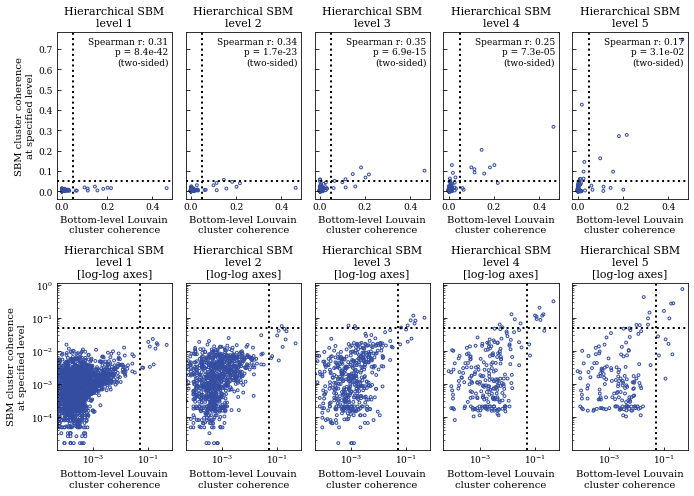

In [294]:
# Plot SBM vs. Louvain coherence head-to-head via cluster matching.

fig, axs = pyp.subplots(figsize=(9.75, 7), ncols=top_agglevel, nrows=2)

## First row, plain scatter.

_axs = axs[0,:]

for agglevel in range(top_agglevel):

    lvc_sbmc_mutinfcomp = d_lvl_lvc_sbmc_mutinfcomp_lsassigned[agglevel]
    _, _lvmutinf, _, _sbmmutinf = zip(*lvc_sbmc_mutinfcomp)
        
    ax = _axs[agglevel]
    
    ax.scatter(_lvmutinf, _sbmmutinf, marker='o', s=8, color=offnavy, facecolor='none')
    
    rspear, rspear_p = spearmanr(_lvmutinf, _sbmmutinf, alternative='two-sided')
    print('Spearman r: {:.2}\np = {:.5f}'.format(rspear, rspear_p))
    
    ax.annotate('Spearman r: {:.2}\np = {:.1e}\n(two-sided)'.format(rspear, rspear_p),
                xy=(0.97, 0.97), xycoords='axes fraction',
                ha='right', va='top', fontsize=9)
    
    ax.set_title('Hierarchical SBM\nlevel {}'.format(agglevel+1))
    ax.set_xlabel('Bottom-level Louvain\ncluster coherence')
    
_axs[0].set_ylabel('SBM cluster coherence\nat specified level')

## Second row, log-log.

_axs = axs[1,:]

for agglevel in range(top_agglevel):

    lvc_sbmc_mutinfcomp = d_lvl_lvc_sbmc_mutinfcomp_lsassigned[agglevel]
    _, _lvmutinf, _, _sbmmutinf = zip(*lvc_sbmc_mutinfcomp)
        
    ax = _axs[agglevel]
    
    ax.scatter(_lvmutinf, _sbmmutinf, marker='o', s=8, color=offnavy, facecolor='none')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_title('Hierarchical SBM\nlevel {}\n[log-log axes]'.format(agglevel+1))
    ax.set_xlabel('Bottom-level Louvain\ncluster coherence')

all_topy0, all_topy1 = np.inf, -np.inf
all_bttmy0, all_bttmy1 = np.inf, -np.inf
all_topx0, all_topx1 = np.inf, -np.inf
all_bttmx0, all_bttmx1 = np.inf, -np.inf
for k in range(top_agglevel):
    _topy0, _topy1 = axs[0,k].get_ylim()
    if _topy0 < all_topy0:
        all_topy0 = _topy0
    if _topy1 > all_topy1:
        all_topy1 = _topy1
    _bttmy0, _bttmy1 = axs[1,k].get_ylim()
    if _bttmy0 < all_bttmy0:
        all_bttmy0 = _bttmy0
    if _bttmy1 > all_bttmy1:
        all_bttmy1 = _bttmy1
    _topx0, _topx1 = axs[0,k].get_xlim()
    if _topx0 < all_topx0:
        all_topx0 = _topx0
    if _topx1 > all_topx1:
        all_topx1 = _topx1
    _bttmx0, _bttmx1 = axs[1,k].get_xlim()
    if _x0 < all_bttmx0:
        all_bttmx0 = _x0
    if _x1 > all_bttmx1:
        all_bttmx1 = _x1

for axi in range(2):
    _axs = axs[axi, :]
    for axj, ax in enumerate(_axs):
        if axi == 0:
            ax.plot([0.05]*2, [all_topy0, all_topy1], ':k')
            ax.plot([all_topx0, all_topx1], [0.05]*2, ':k')
            ax.set_xlim(all_topx0, all_topx1)
            ax.set_ylim(all_topy0, all_topy1)
        else:
            ax.loglog([0.05]*2, [all_bttmy0, all_bttmy1], ':k')
            ax.loglog([all_bttmx0, all_bttmx1], [0.05]*2, ':k')
            ax.set_xlim(all_bttmx0, all_bttmx1)
            ax.set_ylim(all_bttmy0, all_bttmy1)
    
        if axj > 0:
            ax.set_yticklabels([])
    
_axs[0].set_ylabel('SBM cluster coherence\nat specified level')
    
fig.tight_layout()

In [295]:
fig.savefig('matched_comm_coherencescatter.pdf', format='pdf')

## Conspicuousness

In [267]:
# Get community-focused binary hashtag probability distribution splits for
# each aggregated bottom level.

# Split graph into bottom-level communities, get probability dists.
uids_allset = set(chain(*d_agglevel__comm_useranid_partition[top_agglevel].values()))

# Get vocabulary order
_voc = list(set(chain(*d_vidpair_sharedhashtags.values())))
_d_voc_idx = dict([(ht, idx) for idx, ht in enumerate(_voc)])

# Get user -> hashtag dict from above.
_d_user_hts = defaultdict(set)
for uidpair, hts in d_vidpair_sharedhashtags.items():
    for uid in uidpair:
        _d_user_hts[uid].update(hts)

d_agglevel__d_splitbinaryhtdists = {}
d_agglevel__d_splitbinaryhtcountdists = {}
for agglevel in range(top_agglevel):
    
    projected_level_partition = state.project_partition(agglevel, 0)

    d_comm_useranid_Ggiant_agglevel_partition = defaultdict(set)
    for gtv in state.g.vertices():
        comm = projected_level_partition[gtv]
        d_comm_useranid_Ggiant_agglevel_partition[comm].add(d_gtv_nxv[gtv])
    d_comm_useranid_Ggiant_agglevel_partition = dict(d_comm_useranid_Ggiant_agglevel_partition.items())

    d_commfocus_agglevel_splitbinaryhtdists = {str(c): {str(c): {}, 'not_{}'.format(c): {}} \
                                      for c in d_comm_useranid_Ggiant_agglevel_partition.keys()}
    d_commfocus_firstlevel_splitbinaryhtcountdists = {str(c): {str(c): {}, 'not_{}'.format(c): {}} \
                                      for c in d_comm_useranid_Ggiant_agglevel_partition.keys()}
    for comm, comm_uids in d_comm_useranid_Ggiant_agglevel_partition.items():

        # Hashtag probabilities for this first-level community.
        positive_comm_cdist = np.zeros(len(_voc))
        for uid in comm_uids:
            uid_hts = _d_user_hts[uid]
            positive_comm_cdist[[_d_voc_idx[ht] for ht in uid_hts]] += 1
        positive_comm_pdist = positive_comm_cdist/positive_comm_cdist.sum()

        d_commfocus_agglevel_splitbinaryhtdists[str(comm)][str(comm)] = positive_comm_pdist
        d_commfocus_firstlevel_splitbinaryhtcountdists[str(comm)][str(comm)] = positive_comm_cdist

        # Hashtag probabilities for the complement of the first-level community.
        negative_comm_cdist = np.zeros(len(_voc))
        comm_complement_uids = uids_allset - comm_uids
        for uid in comm_complement_uids:
            uid_hts = _d_user_hts[uid]
            negative_comm_cdist[[_d_voc_idx[ht] for ht in uid_hts]] += 1
        negative_comm_pdist = negative_comm_cdist/negative_comm_cdist.sum()

        d_commfocus_agglevel_splitbinaryhtdists[str(comm)]['not_{}'.format(comm)] = negative_comm_pdist
        d_commfocus_firstlevel_splitbinaryhtcountdists[str(comm)]['not_{}'.format(comm)] = negative_comm_cdist
        
    d_agglevel__d_splitbinaryhtdists[agglevel] = d_commfocus_agglevel_splitbinaryhtdists
    d_agglevel__d_splitbinaryhtcountdists[agglevel] = d_commfocus_firstlevel_splitbinaryhtcountdists

    print(agglevel)
    sys.stdout.flush()

0
1
2
3
4


In [375]:
# Save/load binary first-level community-focused binary hashtag probability distribution splits
# for each aggregated bottom-level.

# Save.

fname = 'SBM_agglvl_binary_hashtag_pdistsplits_dict.pkl.bz2'

with bz2.open(fname, mode='wb', compresslevel=9) as f:
    pickle.dump(d_agglevel__d_splitbinaryhtdists, f)


# Load.
with bz2.open(fname, mode='rb', compresslevel=9) as f:
    d_agglevel__d_splitbinaryhtdists = pickle.load(f)

In [266]:
def JSD(d0, d1):
    """
    d0 and d1 are 1-dimensional arrays representing
    probability distributions over the identically-ordered
    sample space.
    
    """
    
    m = d0 + d1
    
    d0_nonzero_inds = np.where(d0 != 0)
    d0p = (d0[d0_nonzero_inds]*np.log2(2*d0[d0_nonzero_inds]/m[d0_nonzero_inds])).sum()
    
    d1_nonzero_inds = np.where(d1 != 0)
    d1p = (d1[d1_nonzero_inds]*np.log2(2*d1[d1_nonzero_inds]/m[d1_nonzero_inds])).sum()
    
    return 0.5*(d0p + d1p)

In [320]:
# Get conspicuousness per bottom-level community.

d_agglevel__d_comm_htinfogain = {}
for agglevel in [0, 1, 2, 3]:

    d_agglevel_comm_htinfogain = {}
    for commstr, splitdict in d_agglevel__d_splitbinaryhtdists[agglevel].items():

        d_agglevel_comm_htinfogain[int(commstr)] = \
                JSD(splitdict[commstr], splitdict['not_' + commstr])
    
    d_agglevel__d_comm_htinfogain[agglevel] = d_agglevel_comm_htinfogain
    
    print(agglevel)
    sys.stdout.flush()

0
1
2
3


### Null conspicuousness

In [324]:
def calculate_null_binarycommunitysplit_JSDs_preservelabelcountpools(useridx_vidcs_dict, rng_seed,
                                                                     vocab_overlap=False):
    """
    Calculate 
    
    Args:
      useridx_vidcs_dict (dict): mapping of user indices to  sets of
      vocabulary indices representing self-labels.  Both user indices
      and vocabulary indices must be integers starting at 0,
      incrementing without gap until their largest value.
    
    """
    
    rng = default_rng(rng_seed)
    
    # Randomly assign vocabulary to users, within separate pools of users
    # having 1, 2, 3, etc. labels.
    _flattened_users = []
    _flattened_vocab = []
    for lablen, lablen_users_vocab in groupby(sorted(useridx_vidcs_dict.items(),
                                                     key=lambda x: len(x[1])),
                     key=lambda x: len(x[1])):

        lablen_flattened_users = []
        lablen_flattened_vocab = []
        for lablen_user, lablen_uservocab in lablen_users_vocab:
            lablen_flattened_users.extend([lablen_user]*len(lablen_uservocab))
            lablen_flattened_vocab.extend(list(lablen_uservocab))

        # Shuffle vocab across users who have exactly lablen labels.
        rng.shuffle(lablen_flattened_vocab)

        # Extend flattened array of assigned labels to users.
        _flattened_users.extend(lablen_flattened_users)
        # Extend flattened array of users assigned to labels.
        _flattened_vocab.extend(lablen_flattened_vocab)

    # Collect shared labels to make graph.
    _null_d_userpair_sharedlabels = defaultdict(set)
    _spi = []
    _spj = []
    _spd = [] # sparse matrix: data[k] is for indices _spi[k], _spj[k]
    for vlabidx, labeluseridxpairgroup in groupby(sorted(zip(_flattened_vocab, _flattened_users),
                                                  key=lambda x: x[0]),
                                           key=lambda x: x[0]):
        _, labeluseridcs = zip(*labeluseridxpairgroup)
        # Get null shared vocab indices per user pair.
        for pair in combinations(labeluseridcs, 2):
            _null_d_userpair_sharedlabels[tuple(sorted(pair))].add(vlabidx)
        # Get null vocab index labeling per user: as arrays of vocabulary length,
        # where only the user's vocab indices = 1, the rest 0.
        for useridx in labeluseridcs:
            _spi.append(useridx)
            _spj.append(vlabidx)
            _spd.append(1)
    # Construct the null user-vocabulary sparse matrix.
    _null_user_vlabelidcs_arr = csr_matrix((_spd, (_spi, _spj)),
                                           shape=(len(useridx_vidcs_dict), len(set(_flattened_vocab))))

    # Null edges and weights for igraph representation.
    _null_edges = []
    _null_weights = []
    for e, elabs in _null_d_userpair_sharedlabels.items():
        _null_edges.append(e)
        _null_weights.append(len(elabs))
        
    _nulluids_allset = set(_flattened_users)

    # Make graph-tool null graph.
    Ggiant_gt = Graph(directed=False)
    edge_weights = Ggiant_gt.new_edge_property('int')
    orig_vertices = Ggiant_gt.new_vertex_property('int')

    _d_vtx_gtidx = {}
    _gtidx = 0
    for (v0, v1), w in zip(_null_edges, _null_weights):
        # Populate the graph with vertices and record the 
        # vertex-to-graphtoolidx mapping.
        for v in [v0, v1]:
            if v not in _d_vtx_gtidx:
                _d_vtx_gtidx[v] = _gtidx
                _gtidx += 1
                gtv = Ggiant_gt.add_vertex()
                orig_vertices[gtv] = v
    
        e = Ggiant_gt.add_edge(Ggiant_gt.vertex(_d_vtx_gtidx[v0]),
                               Ggiant_gt.vertex(_d_vtx_gtidx[v1]))
        edge_weights[e] = int(w)
    Ggiant_gt.edge_properties["weight"] = edge_weights
    Ggiant_gt.vertex_properties["orig_v"] = orig_vertices
    
    # Get the largest component.
    Ggiant_gt = extract_largest_component(Ggiant_gt, directed=False, prune=True)
        
    # Infer hierarchical stochastic block model.
    state = minimize_nested_blockmodel_dl(Ggiant_gt,
                                          state_args=dict(recs=[Ggiant_gt.edge_properties["weight"]],
                                                          rec_types=['discrete-geometric']) )
    
    # Get stats per level of hierarchy.
    quants_perlevel_gt = []
    for agglevel in [0, 1, 2, 3]:
        
        if agglevel+1 > len(state.get_bstack()):
            break
    
        # Translate graph-tool partition into a list of node sets.
        projected_level_partition = state.project_partition(agglevel, 0)
        _d_c_v = {k: set() for k in set(projected_level_partition)}
        for v in state.g.vertices():
            c = projected_level_partition[v]
            # Translate graph-tool vertices back into their original values.
            _d_c_v[c].add(int(v))
        _null_firstlevelcomms = [[state.g.vertex_properties["orig_v"][v] for v in cvs] \
                                 for cvs in _d_c_v.values()]
            
        Q = modularity(state.g, projected_level_partition, gamma=1.0, weight=state.g.edge_properties['weight'])
        
        # Get vocabularies for split binary distinction of 
        # each community vs all others aggregated.  Measure the
        # JSD for each of these splits, and the associated
        # community size.
        _nulluids_allset = set(_flattened_users)
        _focus_community_sizes = []
        _focus_community_split_JSDs = []
        _vocab_overlaps = []
        for comm_uids in _null_firstlevelcomms: # These have been translated to original vertices
                                                # when assigning _null_firstlevelcomms.

            # Hashtag probabilities for this first-level community.
            positive_comm_cdist = np.array(_null_user_vlabelidcs_arr[comm_uids, :].sum(axis=0)[0])
            positive_comm_pdist = positive_comm_cdist/positive_comm_cdist.sum()

            # Hashtag probabilities for the complement of the first-level community.
            comm_complement_uids = list(_nulluids_allset - set(comm_uids))
            negative_comm_cdist = np.array(_null_user_vlabelidcs_arr[comm_complement_uids, :].sum(axis=0)[0])
            negative_comm_pdist = negative_comm_cdist/negative_comm_cdist.sum()

            if vocab_overlap:
                _vocab_overlap = sum((positive_comm_cdist[0] > 0) & (negative_comm_cdist[0] > 0))
                _vocab_overlaps.append(_vocab_overlap)

            # Measure JSD
            d0 = positive_comm_pdist
            d1 = negative_comm_pdist
            m = d0 + d1
            d0_nonzero_inds = np.where(d0 != 0)
            d0p = (d0[d0_nonzero_inds]*np.log2(2*d0[d0_nonzero_inds]/m[d0_nonzero_inds])).sum()
            d1_nonzero_inds = np.where(d1 != 0)
            d1p = (d1[d1_nonzero_inds]*np.log2(2*d1[d1_nonzero_inds]/m[d1_nonzero_inds])).sum()
            jsd = 0.5*(d0p + d1p)
            _focus_community_split_JSDs.append(jsd)

            # Record focus community size associated with this binary
            # split JSD.
            _focus_community_sizes.append(len(comm_uids))
            
        quants_perlevel_gt.append((Q,
                                   len(_null_firstlevelcomms), # number of clusters for this level
                                   _focus_community_sizes,
                                   _focus_community_split_JSDs))
    
    
    
    return (state.g.num_vertices(),
            state.g.num_edges(),
            quants_perlevel_gt)

In [325]:
def collect_null_jsds_by_size_gt(nullresults_list, count_threshold=5):
    
    d_level__null_size_binjsds = {}
    for nullgraph_nvertices, \
            nullgraph_nedges, \
            quants_perlevel_gt in nullresults_list:
                for level, (Q,
                            clustcount,
                            _nullsizes,
                            _nulljsds) in enumerate(quants_perlevel_gt):
                    if level not in d_level__null_size_binjsds:
                        d_level__null_size_binjsds[level] = {}
                    for _nullsize, _nulljsd in zip(_nullsizes, _nulljsds):
                        if _nullsize not in d_level__null_size_binjsds[level]: 
                            d_level__null_size_binjsds[level][_nullsize] = [_nulljsd]
                        else:
                            d_level__null_size_binjsds[level][_nullsize].append(_nulljsd)
                            
    d_level_nullresults = {}
    for level, d_null_size_binjsds in d_level__null_size_binjsds.items():
        
        _nullcommsizes, _nullcommjsdlists = zip(*sorted(d_null_size_binjsds.items(),
                                                      key=lambda x: x[0]))

        nullcommsizes = []
        nullcommsize_jsd_CI90los = []
        nullcommsize_jsd_CI90his = []
        nullcommsize_jsd_means = []
        _nullcommsize_jsdcounts = []
        nullcommsize_jsdcounts = []
        for nullcommsize, nullcommjsdlist in zip(_nullcommsizes, _nullcommjsdlists):
            nulljsdcount = len(nullcommjsdlist)
            _nullcommsize_jsdcounts.append(nulljsdcount)
            if nulljsdcount > count_threshold:
                CIlo, CIhi = np.percentile(nullcommjsdlist, [2.5, 97.5])
                nullcommsize_jsd_CI90los.append(CIlo)
                nullcommsize_jsd_CI90his.append(CIhi)

                nullcommsize_jsd_means.append(np.mean(nullcommjsdlist))
                nullcommsize_jsdcounts.append(nulljsdcount)
                nullcommsizes.append(nullcommsize)

        d_level_nullresults[level] = (nullcommsizes, _nullcommsizes, \
                                      nullcommsize_jsd_CI90los, nullcommsize_jsd_CI90his, nullcommsize_jsd_means, \
                                      _nullcommsize_jsdcounts, nullcommsize_jsdcounts)
        
    return d_level_nullresults

In [ ]:
# Calculate tag-randomization null models!

nullcount = 100

rng_seeds = []
for k in range(nullcount):
    rng_seeds.append(int.from_bytes(os.urandom(4), byteorder='little'))

worker_ingredients = zip([useridx_vidcs_dict]*nullcount,
                         rng_seeds)

print('Starting', datetime.now())
sys.stdout.flush()

tinit = time()
t0 = tinit

results_2 = []
for nk, wtup in enumerate(worker_ingredients):
    
    results_2.append(calculate_null_binarycommunitysplit_JSDs_preservelabelcountpools(*wtup))
    
    if (nk % 100 == 0) and nk != 0:
        tf = time()
        print('{} of {}, {:,.2f} min'.format(nk+1, nullcount, (tf-t0)/60))
        sys.stdout.flush()
        t0 = time()
        
tfinal = time()
        
time_taken = tfinal-t0
print('Ending', datetime.now())
print('Time taken: {:,.2f} min, {:,.1f} s per null'.format(time_taken/60, time_taken/nullcount))

In [351]:
# Load pre-calculated null example.

fname = "QuantifyingCollectiveIdentity_nullconspicuousness_SBM_precalc.pkl"

with open(fname, mode='rb') as f:
    nullresults = pickle.load(f)
    
print('{:,} null simulations'.format(len(nullresults)))

2,000 null simulations


In [338]:
def collect_null_jsds_by_sizebins_gt(nullresults_list, binsize, minbin=1, set_maxbin=None,
                                     minsamplesize=100, sigalpha=0.05):
    
    d_level__null_size_binjsds = {}
    for nullgraph_nvertices, \
            nullgraph_nedges, \
            quants_perlevel_gt in nullresults_list:
                for level, (Q,
                            clustcount,
                            _nullsizes,
                            _nulljsds) in enumerate(quants_perlevel_gt):
                    if level not in d_level__null_size_binjsds:
                        d_level__null_size_binjsds[level] = {}
                    for _nullsize, _nulljsd in zip(_nullsizes, _nulljsds):
                        if _nullsize not in d_level__null_size_binjsds[level]: 
                            d_level__null_size_binjsds[level][_nullsize] = [_nulljsd]
                        else:
                            d_level__null_size_binjsds[level][_nullsize].append(_nulljsd)
    
    d_level_nullbinresults = {}
    for level, d_null_size_binjsds in d_level__null_size_binjsds.items():
        
        _nullcommsizes, _nullcommjsdlists = zip(*sorted(d_null_size_binjsds.items(),
                                                      key=lambda x: x[0]))

        _nullcommsizes = np.array(_nullcommsizes)
        
        if not set_maxbin:
            maxbin = max(_nullcommsizes)
        else:
            maxbin = set_maxbin

        bins = np.arange(minbin, maxbin+1, binsize)
        
        bin_nullcounts = []
        bin_nullCIlos = []
        bin_nullCIhis = []
        for j in range(len(bins)-1):
            bin0, bin1 = bins[j], bins[j+1]
            binned_sizes = list(range(bin0, bin1))
            binned_sizecount = 0
            binned_jsds = []
            for bs in binned_sizes:
                _idcs = np.where(_nullcommsizes == bs)[0]
                _bs_nullcommjsds = list(chain(*[_nullcommjsdlists[ix] for ix in _idcs]))
                binned_sizecount += len(_bs_nullcommjsds)
                binned_jsds.extend(_bs_nullcommjsds)

            bin_nullcounts.append(binned_sizecount)

            if len(binned_jsds) > minsamplesize:
                CIlo, CIhi = np.percentile(binned_jsds, [100*sigalpha/2, 100*(1-sigalpha/2)])
            else:
                CIlo, CIhi = np.nan, np.nan

            bin_nullCIlos.append(CIlo)
            bin_nullCIhis.append(CIhi)
        
        midbin_locs = bins[:-1] + (bins[1:] - bins[:-1])/2
        
        d_level_nullbinresults[level] = (bins, midbin_locs, bin_nullcounts, bin_nullCIlos, bin_nullCIhis)
    
    return d_level_nullbinresults

In [352]:
# Bin null results by community size.

binsize = 100
minsamplesize = 100

d_level_nullbinresults = collect_null_jsds_by_sizebins_gt(nullresults,
                                                          binsize,
                                                          minbin=1,
                                                          set_maxbin=None,
                                                          minsamplesize=minsamplesize,
                                                          sigalpha=0.05)

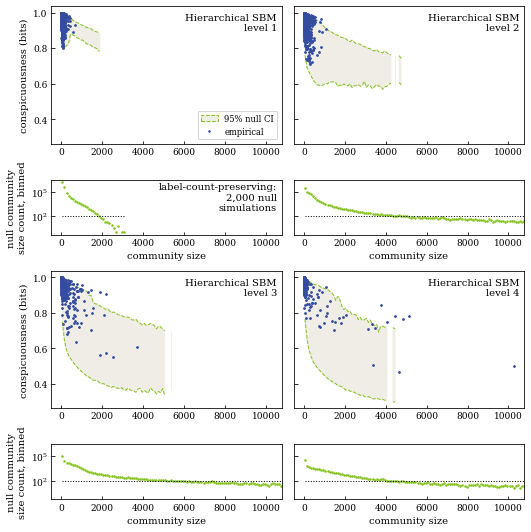

In [371]:
fig = pyp.figure(figsize=(7.5, 7.5))
gs = mpl.gridspec.GridSpec(4, 2, height_ratios=[1, 0.4, 1, 0.4])
axs = np.array([fig.add_subplot(gsp) for gsp in gs]).reshape(4,2)

axgroups = [[axs[0,0], axs[1,0]], [axs[0,1], axs[1,1]],
            [axs[2,0], axs[3,0]], [axs[2,1], axs[3,1]]]

for agglevel in range(len(d_level_nullsizejsdresults)):
    
    axg = axgroups[agglevel]
    
    ax = axg[0]
    
    # Actual measurements.
    
    _comms_infogains = sorted(d_agglevel__d_comm_htinfogain[agglevel].items(),
                              key=lambda x: x[1],
                              reverse=True)

    _sizedict = dict(Counter(state.project_partition(agglevel, 0)))

    _infogains = []
    _sizes = []
    for comm, infogain in _comms_infogains:
        _size = _sizedict[int(comm)]
        _infogains.append(infogain)
        _sizes.append(_size)
    _infogains = np.array(_infogains)
    _sizes = np.array(_sizes)
    
    #ax.scatter(_sizes, _infogains, color='tab:purple', s=2, zorder=1)
    ax.scatter(_sizes, _infogains, marker='.', s=12,
           color=offnavy, alpha=1, label='empirical', rasterized=True, zorder=2)
    
    # Null measurements.
    
    null2_bins, null2_midbin_locs, \
            null2_bin_nullcounts, null2_bin_nullCIlos, \
            null2_bin_nullCIhis = d_level_nullbinresults[agglevel]
    
    ax.fill_between(x=null2_midbin_locs, y1=null2_bin_nullCIlos, y2=null2_bin_nullCIhis,
                    color=FINALTOPE, alpha=1, label='label-count-preserving\nnull 95% CI',
                    zorder=0)
    ax.plot(null2_midbin_locs, null2_bin_nullCIlos, linestyle='--', color=lime, linewidth=1, zorder=1)
    ax.plot(null2_midbin_locs, null2_bin_nullCIhis, linestyle='--', color=lime, linewidth=1, zorder=1)

    """ax.annotate('{:,} null\nsimulations'.format(len(nullresults)),
                xy=(0.95, 0.05), xycoords="axes fraction",
                va='bottom', ha='right')"""
    
    #ax.set_title('Hierarchical SBM\nlevel {}'.format(agglevel+1))
    ax.annotate('Hierarchical SBM\nlevel {}'.format(agglevel+1),
                xy=(0.98, 0.95), xycoords="axes fraction",
                va='top', ha='right')
    
    ax = axg[1] # Plot the number of label-count-preserving null jsds I collected

    ax.semilogy(null2_midbin_locs, null2_bin_nullcounts, '.', markersize=3, color=lime, alpha=1)

    ax.semilogy(null2_midbin_locs, [minsamplesize]*len(null2_midbin_locs), 'k:', linewidth=1)

    ax.set_xlabel('community size')
    
    

#legout = axgroups[0][0].legend(loc='lower right', fontsize='small')
leglinehandles = [mpl.patches.Rectangle(xy=(0., 0.), width=1., height=1., facecolor=FINALTOPE,
                                        linestyle='--', linewidth=1, edgecolor=lime),
                  mpl.lines.Line2D([0], [0], color=offnavy, linewidth=0, marker='.', ms=3)]
leglinelabs = ['95% null CI',
               'empirical']
kwargs = {'loc': 'lower right', 'fontsize': 'small'}
leg = axgroups[0][0].legend(leglinehandles, leglinelabs, **kwargs)


axgroups[0][1].annotate('label-count-preserving:\n{:,} null\nsimulations'.format(len(nullresults)),
            xy=(0.98, 0.95), xycoords="axes fraction",
            va='top', ha='right')
axgroups[0][0].set_ylabel('conspicuousness (bits)')
axgroups[2][0].set_ylabel('conspicuousness (bits)')
axgroups[0][1].set_ylabel('null community\nsize count, binned')
axgroups[2][1].set_ylabel('null community\nsize count, binned')

all_topy0, all_topy1 = np.inf, -np.inf
all_bttmy0, all_bttmy1 = np.inf, -np.inf
all_x0, all_x1 = np.inf, -np.inf
for k in [0,1,2,3]:
    _topy0, _topy1 = axgroups[k][0].get_ylim()
    if _topy0 < all_topy0:
        all_topy0 = _topy0
    if _topy1 > all_topy1:
        all_topy1 = _topy1
    _bttmy0, _bttmy1 = axgroups[k][1].get_ylim()
    if _bttmy0 < all_bttmy0:
        all_bttmy0 = _bttmy0
    if _bttmy1 > all_bttmy1:
        all_bttmy1 = _bttmy1
    _x0, _x1 = axgroups[k][1].get_xlim()
    if _x0 < all_x0:
        all_x0 = _x0
    if _x1 > all_x1:
        all_x1 = _x1
for k in [0,1,2,3]:
    #axgroups[k][0].plot([600]*2, [all_topy0, all_topy1], ':k') # vertical line
    axgroups[k][0].set_ylim(all_topy0, all_topy1)
    """axgroups[k][0].set_xscale('log')
    axgroups[k][1].set_xscale('log')
    axgroups[k][0].set_xlim(1, max(_sizes)+500)
    axgroups[k][1].set_xlim(1, max(_sizes)+500)"""
    axgroups[k][0].set_xlim(-500, max(_sizes)+500)
    axgroups[k][1].set_xlim(-500, max(_sizes)+500)
    axgroups[k][1].set_ylim(all_bttmy0, all_bttmy1)
for k in [1, 3]:
    axgroups[k][0].set_yticklabels([])
    axgroups[k][1].set_yticklabels([])
    
fig.tight_layout()

In [350]:
fig.savefig('SBMlevels_conspic_v_size_nullsampsizes.pdf', format='pdf', dpi=300)